In [119]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV

from sklearn.neural_network import MLPRegressor

# Helper Functions

In [2]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [3]:
def plot_correlations(df_all, fig_title,correlation_type, font_size):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=(25,25))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':font_size})
    plt.title(fig_title, fontsize=20)
    plt.show()

In [33]:
def plot_importances(forest, varnames,plot_title):
    tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    df_plot = pd.DataFrame({'tree_indices': tree_indices, 'importances': importances, 'std':std, 'varnames':varnames})
    df_plot = df_plot.sort_values(by='importances').reset_index(drop=True)
    #print(df_plot)
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.barh(df_plot.index, df_plot['importances'], height=0.7,xerr = std)
    ax1.set_yticks(df_plot.index)
    ax1.set_yticklabels(df_plot['varnames'])
    ax1.set_ylim((-0.5, len(df_plot['importances'])))
    fig.tight_layout()
    plt.title(plot_title)
    plt.show()

In [5]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [6]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*0.1)) #left hand approximation, assuming bins are 5 wide

# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.nanmean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def MeAD(y_pred,y_test): #aka median error
    return np.nanmedian(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def median_percent_error(y_pred,y_test):
    return(np.nanmedian(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.nanmedian(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

In [7]:
def scatter_plot(df_plot,x_plot,y_plot,point_hue, point_style, point_size, point_size_range,plot_title):
    fig,ax=plt.subplots(figsize=(10,10))
    sns.scatterplot(data =df_plot, x=x_plot,y=y_plot,hue=point_hue,
                    style=point_style,size=point_size,sizes=point_size_range,ax=ax,cmap='vlag')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(plot_title)
    plt.show()

In [8]:
def combine_years(base_file_name, years): # for when all of one year is in a dataframe
    df_all = pd.DataFrame()
    for yr in years:
        filename = base_file_name.replace('YYYY', str(yr))
        df = pd.read_csv(filename)
        df_all = pd.concat([df_all, df], axis=0).reset_index(drop=True)
    return df_all

In [9]:
def combine_per_fire_csv(ids, prefix, str_check): #for when a variable is split by fire, takes a list of irwinids
    df_all = pd.DataFrame()
    for i_d in ids:
        for fname in os.listdir(prefix):
            if fname.startswith(i_d) & (str_check in fname):
                df_fire = pd.read_csv(prefix+fname)
                df_all = pd.concat([df_all, df_fire], axis=0).reset_index(drop=True)
    return df_all

In [10]:
def add_to_features(feats, data_to_add): #feats has the multi index of irwinID, day
    #multiindex = data_to_add.set_index(['irwinID', 'day'])
    feats = pd.merge(feats, data_to_add, how='inner', on=['irwinID', 'day']).drop(columns='Unnamed: 0')
    return feats

In [11]:
def generate_feature_vector(years, is_weighted, features_to_use):
    if 'rave' in features_to_use:
        rave = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_RAVE_Unweighted_12Z_day_start.csv', years)
        print('rave', len(rave))
        features = rave[['irwinID','day']].set_index(['irwinID', 'day'])
        features = add_to_features(features, rave).drop_duplicates()
        
    if 'hwp' in features_to_use:
        hwp = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HWP_'+is_weighted+'_12Z_day_start.csv', years)
        print('hwp', len(hwp))
        features = add_to_features(features, hwp).drop_duplicates()

    if 'hdw' in features_to_use:
        hdw = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HDW_'+is_weighted+'_12Z_day_start.csv', years)
        print('hdw', len(hdw))
        features = add_to_features(features, hdw).drop_duplicates()
        
    if 'resources' in features_to_use:
        resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources/', '')
        print('resources', len(resources))
        features = add_to_features(features, resources).drop_duplicates()
        
    if 'pft' in features_to_use:
        pft = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pft/', is_weighted)
        print('pft', len(pft))
        features = add_to_features(features, pft).drop_duplicates()
        
    if 'smops' in features_to_use:
        smops = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SMOPS_'+is_weighted+'_12Z_day_start.csv', years)
        print('smops', len(smops))
        features = add_to_features(features, smops).drop_duplicates()

    if 'imerg' in features_to_use:
        imerg = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_IMERG_FWI_'+is_weighted+'_12Z_day_start.csv', years)
        print('imerg', len(imerg))
        features = add_to_features(features, imerg).drop_duplicates()

    if 'pws' in features_to_use:
        pws = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_PWS_'+is_weighted+'_12Z_day_start.csv', years)
        print('pws', len(pws))
        features = add_to_features(features, pws).drop_duplicates()
        
    if 'loading' in features_to_use:
        loading = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_LOADING_'+is_weighted+'_12Z_day_start.csv', years)
        print('loading', len(loading))
        features = add_to_features(features, loading).drop_duplicates()

    if 'ncar' in features_to_use:
        ncar = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_ncar/', is_weighted)
        print('ncar', len(ncar))
        features = add_to_features(features, ncar).drop_duplicates()

    
    if 'esi' in features_to_use:
        esi = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_esi/', is_weighted)
        print('esi', len(esi))
        features = add_to_features(features, esi).drop_duplicates()
        
    if 'chi' in features_to_use:
        chi_2019 = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_CHI_'+is_weighted+'_12Z_day_start.csv', years)
        chi_2020 = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_chi/', is_weighted)
        chi= pd.concat([chi_2019, chi_2020], axis=0).reset_index(drop=True)
        print('chi', len(chi))
        features = add_to_features(features, chi).drop_duplicates()

        
        
    return features


In [12]:
def find_outliers(df, col_name):
    quantiles = df[col_name].quantile(q=[.25, .5, .75])
    iqr = quantiles[0.75]-quantiles[0.25]
    lower_fence = quantiles[0.50]-(1.5*iqr)
    upper_fence = quantiles[0.50]+(1.5*iqr)
    print('lower and upper fences are: '+ str(lower_fence) + ', '+ str(upper_fence))
    df[col_name+'_is_outlier'] = np.where((df[col_name]<=lower_fence)| (df[col_name]>=upper_fence), True,False)
    return df

In [13]:
def get_relative_features(df, names): #to today/yesterday, flip it later
    for name in names:
        df['rel_'+name] = df[name]/df[name+'_1']
    return df

# Turn the FRP problem into a classification problem and see how persistence performs for each class

In [ ]:
#combine the two years of training RAVE that we have
rave_2019 = pd.read_csv('./fire_features_3/ClippedFires2019_Daily_RAVE_Unweighted_12Z_day_start.csv')
rave_2020 = pd.read_csv('./fire_features_3/ClippedFires2020_Daily_RAVE_Unweighted_12Z_day_start.csv')

rave= pd.concat([rave_2019, rave_2020], axis=0).reset_index(drop=True)
print(np.max(rave['FRP_MEAN'].values))

print(len(np.unique(rave['irwinID'])), len(np.unique(rave_2019['irwinID'])), len(np.unique(rave_2020['irwinID'])))

ids = np.unique(rave['irwinID'])

#get the yesterday FRPs
rave_all = pd.DataFrame()
for i_d in ids:
    rave_fire = rave[rave['irwinID']==i_d]
    rave_fire_shifted = shift_ndays(rave_fire,1, ['FRP_MEAN'], ['Yesterday_FRP'],'day') #this is daily, contains nans
    #print(rave_fire_shifted[['FRP_MEAN', 'Yesterday_FRP']])
    #rave_fire_shifted = rave_fire_shifted[~rave_fire_shifted['FRP_MEAN'].isna()]
    rave_fire_shifted['day of fire from 0'] = np.arange((len(rave_fire_shifted)))

    rave_all = pd.concat([rave_all, rave_fire_shifted], axis=0).reset_index(drop=True)

#some other options for trget variables
rave_all['SCALING_FACTOR'] = rave_all['FRP_MEAN']/rave_all['Yesterday_FRP']
rave_all['LOG_FRP_MEAN'] = np.log10(rave_all['FRP_MEAN'])
rave_all['LOG_SCALING_FACTOR'] = np.log10(rave_all['SCALING_FACTOR'])
print(len(rave_all))

# drop fires that last one day
rave_all_reindex = rave_all.reset_index()
rave_all_ge = rave_all_reindex[rave_all_reindex.groupby('irwinID')['day'].transform('size').ge(2)].reset_index(drop=True)
print(len(np.unique(rave_all_ge['irwinID'])), len(rave_all_ge))


#replace infs with nans
rave_all_ge.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop nans
rave_all_ge = rave_all_ge.dropna(axis=0,how='any').reset_index(drop=True)
print(len(rave_all_ge))

In [ ]:
rave_with_outliers = find_outliers(rave_all_ge, 'LOG_SCALING_FACTOR')

In [ ]:
fig, ax= plt.subplots(figsize=(10,10))
rave_with_outliers['LOG_SCALING_FACTOR'].plot.hist(bins=20,ax=ax)
rave_with_outliers['LOG_SCALING_FACTOR'].iloc[np.where(rave_with_outliers['LOG_SCALING_FACTOR_is_outlier']==False)].plot.hist(bins=8, ax=ax)
rave_with_outliers['persistence'] = np.ones(len(rave_with_outliers))
rave_with_outliers['log_persistence'] = np.log10(np.ones(len(rave_with_outliers)))
mu = np.mean(rave_all_ge['LOG_SCALING_FACTOR'])
sigma = np.std(rave_all_ge['LOG_SCALING_FACTOR'])
print('Mean and STDEV for the blue curve is')
print('mu = '+ str(mu))
print('sigma = '+ str(sigma))



In [ ]:
def label_function(val):
    return f'{val / 100 * len(rave_no_outliers):.0f}\n{val:.0f}%'

In [ ]:
#remove outliers
rave_no_outliers = rave_with_outliers.iloc[np.where(rave_with_outliers['LOG_SCALING_FACTOR_is_outlier']==False)]
print(len(rave_no_outliers))
#split the no outlier category based on standard deviations of the full dist
rave_cat = pd.cut(rave_no_outliers['LOG_SCALING_FACTOR'].values, bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                  labels=['large_decrease','no_change','large_increase'])

rave_no_outliers['change_category'] = rave_cat
print(rave_no_outliers['change_category'])

rave_no_outliers.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('No change is LOG_SCALING_FACTOR within .5$\sigma$ from mean')
plt.tight_layout()
plt.show()

In [ ]:
rave_no_outliers.groupby('change_category').size()

In [ ]:
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = rave_no_outliers.iloc[np.where(rave_no_outliers['change_category']=='no_change')]
rave_increase = rave_no_outliers.iloc[np.where(rave_no_outliers['change_category']=='large_increase')]
rave_decrease = rave_no_outliers.iloc[np.where(rave_no_outliers['change_category']=='large_decrease')]

print('LogPersistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_persistence'], rave_no_change['LOG_SCALING_FACTOR'])))
print('for large increases: ' + str(RMSE(rave_increase['log_persistence'], rave_increase['LOG_SCALING_FACTOR'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_persistence'], rave_decrease['LOG_SCALING_FACTOR'])))
print()

print('Log Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_persistence'], rave_no_change['LOG_SCALING_FACTOR'])))
print('for large increases: ' + str(MAD(rave_increase['log_persistence'], rave_increase['LOG_SCALING_FACTOR'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_persistence'], rave_decrease['LOG_SCALING_FACTOR'])))
print()

print('Log Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_persistence'], rave_no_change['LOG_SCALING_FACTOR'])))
print('for large increases: ' + str(MeAD(rave_increase['log_persistence'], rave_increase['LOG_SCALING_FACTOR'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_persistence'], rave_decrease['LOG_SCALING_FACTOR'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['log_persistence'], rave_no_change['LOG_SCALING_FACTOR'])
thresh_increase, acc_increase = REC(rave_increase['log_persistence'], rave_increase['LOG_SCALING_FACTOR'])
thresh_decrease, acc_decrease = REC(rave_decrease['log_persistence'], rave_decrease['LOG_SCALING_FACTOR'])


print('Log Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'Persistence Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


# how does persistence perform on predicting the  scaling factor?
print('Persistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['persistence'], rave_no_change['SCALING_FACTOR'])))
print('for large increases: ' + str(RMSE(rave_increase['persistence'], rave_increase['SCALING_FACTOR'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['persistence'], rave_decrease['SCALING_FACTOR'])))
print()

print('Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['persistence'], rave_no_change['SCALING_FACTOR'])))
print('for large increases: ' + str(MAD(rave_increase['persistence'], rave_increase['SCALING_FACTOR'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['persistence'], rave_decrease['SCALING_FACTOR'])))
print()

print('Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['persistence'], rave_no_change['SCALING_FACTOR'])))
print('for large increases: ' + str(MeAD(rave_increase['persistence'], rave_increase['SCALING_FACTOR'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['persistence'], rave_decrease['SCALING_FACTOR'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['persistence'], rave_no_change['SCALING_FACTOR'])
thresh_increase, acc_increase = REC(rave_increase['persistence'], rave_increase['SCALING_FACTOR'])
thresh_decrease, acc_decrease = REC(rave_decrease['persistence'], rave_decrease['SCALING_FACTOR'])


print('Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'Persistence Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()



# Turn the FRP problem into a classification problem and look to see how weather performs as an index for each class
Use the following features: ['rave', 'hwp', 'hdw', 'resources', 'pft']

In [ ]:
#get 2019 and 2020

features = generate_feature_vector([2019,2020], 'Weighted', ['rave'])#, 'hwp', 'hdw', 'resources', 'pft']) #weighetd 2020 fires

# drop fires that last one day
features_reindex = features.reset_index()
print(len(np.unique(features_reindex['irwinID'])), len(features_reindex))

features_ge = features_reindex[features_reindex.groupby('irwinID')['day'].transform('size').ge(2)].reset_index(drop=True)
print(len(np.unique(features_ge['irwinID'])), len(features_ge))

print(features_ge)


In [ ]:
#shift the features
events = np.unique(features_ge['irwinID']) #all the incidents

features_to_shift = features_ge.columns.values[2:]
features_shifted = []
print(features_to_shift)

for ii in range(len(features_to_shift)):
    features_shifted.append(features_to_shift[ii]+'_1')
    
features_with_shifts_weighted = pd.DataFrame()
for jj in range(len(events)):
    df_fire_weighted = features_ge[features_ge['irwinID']==events[jj]]
    df_fire_shifted_weighted = shift_ndays(df_fire_weighted, 1, features_to_shift, features_shifted, 'day')

    features_with_shifts_weighted = pd.concat([features_with_shifts_weighted, df_fire_shifted_weighted], axis=0).reset_index(drop=True)

    #get the scaling factor
features_with_shifts_weighted['Scaling_Factor'] = features_with_shifts_weighted['FRP_MEAN']/features_with_shifts_weighted['FRP_MEAN_1']

#get the log of the scaling factor
features_with_shifts_weighted['Log_Scaling_Factor']= np.log10(features_with_shifts_weighted['Scaling_Factor'])

#replace infs with nans
features_with_shifts_weighted.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop nans
features_with_shifts_weighted = features_with_shifts_weighted.dropna(axis=0,how='any').reset_index(drop=True)
print(len(features_with_shifts_weighted))

#get the outliers
features_with_shifts_weighted = find_outliers(features_with_shifts_weighted, 'Log_Scaling_Factor')
print(len(features_with_shifts_weighted[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]))
print(features_with_shifts_weighted.head()) #this is ordered by the irwinID, so 2019 and 2020 will be somewhat jumbled

In [ ]:
features_relative = get_relative_features(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'PFT'])
features_relative['log_rel_hwp'] = np.log10(features_relative['rel_hwp'])
features_relative['log_rel_hd0w0'] = np.log10(features_relative['rel_hd0w0'])
features_relative['log_rel_PFT'] = np.log10(features_relative['rel_PFT'])

#PFT/HWP
features_relative['rel_hwp_pft'] = features_relative['rel_hwp']*features_relative['rel_PFT']
features_relative['log_rel_hwp_pft'] = np.log10(features_relative['rel_hwp_pft'])


#Contained HWP
features_relative['cont_rel_hwp'] = (1-(features_relative['percent_contained_1']/100))*features_relative['rel_hwp']
features_relative['log_cont_rel_hwp']= np.log10(features_relative['cont_rel_hwp'])

#Contained HWP
features_relative['cont_rel_hd0w0'] = (1-(features_relative['percent_contained_1']/100))*features_relative['rel_hd0w0']
features_relative['log_cont_rel_hd0w0'] = np.log10(features_relative['cont_rel_hd0w0'])



features_relative.head()

In [ ]:
#get mu and sigma from the distribution with the outliers
mu = np.mean(features_relative['Log_Scaling_Factor'])
sigma = np.std(features_relative['Log_Scaling_Factor'])
print('Mean and STDEV for the blue curve is')
print('mu = '+ str(mu))
print('sigma = '+ str(sigma))

In [ ]:
#drop outliers and nans
features_no_outliers_weighted = features_relative[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]
features_no_outliers_weighted = features_no_outliers_weighted.replace([np.inf, -np.inf], np.nan) #if scaling factor is infinity, GET RID
features_no_outliers_weighted= features_no_outliers_weighted.dropna(axis=0,how='any').reset_index(drop=True) #drop any because persistence will always be 0

features_no_outliers_weighted['persistence'] = np.ones(len(features_no_outliers_weighted))
features_no_outliers_weighted['log_persistence'] = np.zeros(len(features_no_outliers_weighted))

print(len(features_no_outliers_weighted))

In [ ]:
def label_function(val):
    return f'{val / 100 * len(features_no_outliers_weighted):.0f}\n{val:.0f}%'

#split the data!
rave_cat = pd.cut(features_no_outliers_weighted['Log_Scaling_Factor'].values, bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                  labels=['large_decrease','no_change','large_increase'])

features_no_outliers_weighted['change_category'] = rave_cat
print(features_no_outliers_weighted['change_category'])

features_no_outliers_weighted.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('No change is LOG_SCALING_FACTOR within .5$\sigma$ from mean')
plt.tight_layout()
plt.show()

## Histograms of features by category (come back to this)

In [ ]:
features_no_outliers_weighted['log_rel_hwp'] = np.log10(features_no_outliers_weighted['rel_hwp'])
print(features_no_outliers_weighted['log_rel_hwp'].values)
features_no_outliers_weighted.hist(column='log_rel_hwp', bins=20)
plt.show()

In [ ]:
# find the outliers in rel_hwp
features_no_outliers_weighted = find_outliers(features_no_outliers_weighted, 'log_rel_hwp')
features_no_outliers_weighted = find_outliers(features_no_outliers_weighted, 'rel_PFT')

features_no_hwp_outliers_weighted = features_no_outliers_weighted[(features_no_outliers_weighted['log_rel_hwp_is_outlier']==False)]
features_no_pft_outliers_weighted = features_no_outliers_weighted[(features_no_outliers_weighted['rel_PFT_is_outlier']==False)]


features_no_hwp_outliers_weighted

In [ ]:
#training_variables=['rel_hwp', 'rel_PFT','percent_contained_1']
#define points values by group
A = features_no_hwp_outliers_weighted.loc[features_no_hwp_outliers_weighted['change_category'] == 'no_change', 'rel_hwp']
B = features_no_hwp_outliers_weighted.loc[features_no_hwp_outliers_weighted['change_category'] == 'large_increase', 'rel_hwp']
C = features_no_hwp_outliers_weighted.loc[features_no_hwp_outliers_weighted['change_category'] == 'large_decrease', 'rel_hwp']

#add three histograms to one plot
plt.hist(A, alpha=0.5, label='no_change')
plt.hist(B, alpha=0.5, label='large_increase')
plt.hist(C, alpha=0.5, label='large_decrease')

#add plot title and axis labels
plt.title('rel_hwp Distribution by change category')
plt.xlabel('rel_hwp')
plt.ylabel('Frequency')

#add legend
plt.legend(title='change category', bbox_to_anchor=(1.05, 1.05))

#display plot
plt.show()

In [ ]:
#define points values by group
A = features_no_pft_outliers_weighted.loc[features_no_pft_outliers_weighted['change_category'] == 'no_change', 'rel_PFT']
B = features_no_pft_outliers_weighted.loc[features_no_pft_outliers_weighted['change_category'] == 'large_increase', 'rel_PFT']
C = features_no_pft_outliers_weighted.loc[features_no_pft_outliers_weighted['change_category'] == 'large_decrease', 'rel_PFT']

#add three histograms to one plot
plt.hist(A, alpha=0.5, label='no_change')
plt.hist(B, alpha=0.5, label='large_increase')
plt.hist(C, alpha=0.5, label='large_decrease')

#add plot title and axis labels
plt.title('rel_PFT Distribution by change category')
plt.xlabel('rel_PFT')
plt.ylabel('Frequency')

#add legend
plt.legend(title='change category', bbox_to_anchor=(1.05, 1.05))

#display plot
plt.show()

## Playing with the index

### Use PFT * HWP as a scaling factor

In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='no_change')]
rave_increase = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_increase')]
rave_decrease = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_decrease')]

print('Log Persistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_rel_hwp_pft'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(RMSE(rave_increase['log_rel_hwp_pft'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_rel_hwp_pft'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_rel_hwp_pft'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MAD(rave_increase['log_rel_hwp_pft'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_rel_hwp_pft'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_rel_hwp_pft'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MeAD(rave_increase['log_rel_hwp_pft'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_rel_hwp_pft'], rave_decrease['Log_Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['rel_hwp_pft'], rave_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(rave_increase['rel_hwp_pft'], rave_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(rave_decrease['rel_hwp_pft'], rave_decrease['Scaling_Factor'])

thresh_persistence_no_change, acc_persistence_no_change = REC(rave_no_change['persistence'], rave_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(rave_increase['persistence'], rave_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(rave_decrease['persistence'], rave_decrease['Scaling_Factor'])


print('Log Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'PFT*HWP No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'PFT*HWP Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'PFT*HWP Large Decrease')

plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Use PFT as a scaling factor

In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='no_change')]
rave_increase = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_increase')]
rave_decrease = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_decrease')]

print('Log Persistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_rel_PFT'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(RMSE(rave_increase['log_rel_PFT'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_rel_PFT'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_rel_PFT'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MAD(rave_increase['log_rel_PFT'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_rel_PFT'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_rel_PFT'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MeAD(rave_increase['log_rel_PFT'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_rel_PFT'], rave_decrease['Log_Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['rel_PFT'], rave_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(rave_increase['rel_PFT'], rave_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(rave_decrease['rel_PFT'], rave_decrease['Scaling_Factor'])

thresh_persistence_no_change, acc_persistence_no_change = REC(rave_no_change['persistence'], rave_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(rave_increase['persistence'], rave_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(rave_decrease['persistence'], rave_decrease['Scaling_Factor'])


print('Log Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'PFT No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'PFT Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'PFT Large Decrease')

plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Use contained HWP as the scaling factor

In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='no_change')]
rave_increase = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_increase')]
rave_decrease = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_decrease')]

print('Log Persistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_cont_rel_hwp'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(RMSE(rave_increase['log_cont_rel_hwp'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_cont_rel_hwp'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_cont_rel_hwp'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MAD(rave_increase['log_cont_rel_hwp'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_cont_rel_hwp'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_cont_rel_hwp'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MeAD(rave_increase['log_cont_rel_hwp'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_cont_rel_hwp'], rave_decrease['Log_Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['cont_rel_hwp'], rave_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(rave_increase['cont_rel_hwp'], rave_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(rave_decrease['cont_rel_hwp'], rave_decrease['Scaling_Factor'])

thresh_persistence_no_change, acc_persistence_no_change = REC(rave_no_change['persistence'], rave_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(rave_increase['persistence'], rave_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(rave_decrease['persistence'], rave_decrease['Scaling_Factor'])


print('Log Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'Contained HWP No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'Contained HWP Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'Contained HWP Large Decrease')

plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Use HWP as a scaling Factor

In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='no_change')]
rave_increase = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_increase')]
rave_decrease = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_decrease')]

print('Log rel_hwp performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_rel_hwp'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(RMSE(rave_increase['log_rel_hwp'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_rel_hwp'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log rel_hwp performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_rel_hwp'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MAD(rave_increase['log_rel_hwp'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_rel_hwp'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log rel_hwp performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_rel_hwp'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MeAD(rave_increase['log_rel_hwp'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_rel_hwp'], rave_decrease['Log_Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['rel_hwp'], rave_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(rave_increase['rel_hwp'], rave_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(rave_decrease['rel_hwp'], rave_decrease['Scaling_Factor'])

thresh_persistence_no_change, acc_persistence_no_change = REC(rave_no_change['persistence'], rave_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(rave_increase['persistence'], rave_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(rave_decrease['persistence'], rave_decrease['Scaling_Factor'])


print('rel_hwp performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'HWP No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'HWP Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'HWP Large Decrease')

plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Use contained HD0W0 as a scaling factor

In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='no_change')]
rave_increase = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_increase')]
rave_decrease = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_decrease')]

print('Log Persistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_cont_rel_hd0w0'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(RMSE(rave_increase['log_cont_rel_hd0w0'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_cont_rel_hd0w0'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_cont_rel_hd0w0'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MAD(rave_increase['log_cont_rel_hd0w0'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_cont_rel_hd0w0'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_cont_rel_hd0w0'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MeAD(rave_increase['log_cont_rel_hd0w0'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_cont_rel_hd0w0'], rave_decrease['Log_Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['cont_rel_hd0w0'], rave_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(rave_increase['cont_rel_hd0w0'], rave_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(rave_decrease['cont_rel_hd0w0'], rave_decrease['Scaling_Factor'])

thresh_persistence_no_change, acc_persistence_no_change = REC(rave_no_change['persistence'], rave_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(rave_increase['persistence'], rave_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(rave_decrease['persistence'], rave_decrease['Scaling_Factor'])


print('Log Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'Contained HD0W0 No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'Contained HD0W0 Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'Contained HD0W0 Large Decrease')

plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Use HD0W0 as a scaling factor

In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?
rave_no_change = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='no_change')]
rave_increase = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_increase')]
rave_decrease = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted['change_category']=='large_decrease')]

print('Log Persistence performance for RMSE:')
print('for no change: ' + str(RMSE(rave_no_change['log_rel_hd0w0'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(RMSE(rave_increase['log_rel_hd0w0'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(RMSE(rave_decrease['log_rel_hd0w0'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MAD:')
print('for no change: ' + str(MAD(rave_no_change['log_rel_hd0w0'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MAD(rave_increase['log_rel_hd0w0'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MAD(rave_decrease['log_rel_hd0w0'], rave_decrease['Log_Scaling_Factor'])))
print()

print('Log Persistence performance for MeAD:')
print('for no change: ' + str(MeAD(rave_no_change['log_rel_hd0w0'], rave_no_change['Log_Scaling_Factor'])))
print('for large increases: ' + str(MeAD(rave_increase['log_rel_hd0w0'], rave_increase['Log_Scaling_Factor'])))
print('for for large decreases:  ' + str(MeAD(rave_decrease['log_rel_hd0w0'], rave_decrease['Log_Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(rave_no_change['rel_hd0w0'], rave_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(rave_increase['rel_hd0w0'], rave_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(rave_decrease['rel_hd0w0'], rave_decrease['Scaling_Factor'])

thresh_persistence_increase, acc_persistence_increase = REC(rave_increase['persistence'], rave_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(rave_decrease['persistence'], rave_decrease['Scaling_Factor'])


print('Log Persistence performance for AUC:')
print('for no change: ' + str(AUC(acc_no_change)))
print('for large increases: ' + str(AUC(acc_increase)))
print('for for large decreases:  ' + str(AUC(acc_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k--',  label = 'HD0W0 No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'HD0W0 Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'HD0W0 Large Decrease')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')

plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

## Machine Learning (predicting the class)


In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']

test_irwin_ids = [ac['irwinID'].values[0][2:38]]#, wf['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))

In [ ]:
data_train = features_no_outliers_weighted.iloc[np.where(~features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_train), len(data_test), len(features_no_outliers_weighted))

In [ ]:
def label_function(val):
    return f'{val / 100 * len(data_test):.0f}\n{val:.0f}%'

data_test.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Test Data')
plt.tight_layout()
plt.show()


def label_function(val):
    return f'{val / 100 * len(data_train):.0f}\n{val:.0f}%'

data_train.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Train Data')
plt.tight_layout()
plt.show()

In [ ]:
training_variables=['rel_hwp', 'rel_PFT','percent_contained_1']

rf_class = RandomForestClassifier(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_class.fit(data_train.loc[:, training_variables], data_train.loc[:, ['change_category']])

print(rf_class.oob_score_)

data_test['predicted_change_category'] = rf_class.predict(data_test.loc[:,training_variables])

plot_importances(rf_class, training_variables,'First Classifier RF')

In [ ]:
conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_change_category'])
columns = ['decrease', 'increase', 'no change']
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)

# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')

plt.show()

## Machine learning (one RF for each class)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
data_train = features_no_outliers_weighted.iloc[np.where(~features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_train), len(data_test), len(features_no_outliers_weighted))

In [ ]:
def label_function(val):
    return f'{val / 100 * len(data_test):.0f}\n{val:.0f}%'

data_test.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Test Data')
plt.tight_layout()
plt.show()


def label_function(val):
    return f'{val / 100 * len(data_train):.0f}\n{val:.0f}%'

data_train.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Train Data')
plt.tight_layout()
plt.show()

In [ ]:
data_test

In [ ]:
data_train_increase = data_train[data_train['change_category']=='large_increase']
data_test_increase = data_test[data_test['change_category']=='large_increase']
print(len(data_train_increase), len(data_test_increase))

training_variables=['rel_hwp', 'rel_PFT','percent_contained_1']

rf_increase = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_increase.fit(data_train_increase.loc[:, training_variables], data_train_increase.loc[:, ['Scaling_Factor']])

print(rf_increase.oob_score_)

data_test_increase['RF_SF'] = rf_increase.predict(data_test_increase.loc[:,training_variables])

plot_importances(rf_increase, training_variables,'Increase RF')

print(data_test_increase[['irwinID','datetime','Scaling_Factor', 'RF_SF']])

In [ ]:
data_train_decrease = data_train[data_train['change_category']=='large_decrease']
data_test_decrease = data_test[data_test['change_category']=='large_decrease']
print(len(data_train_decrease), len(data_test_decrease))

training_variables=['rel_hwp', 'rel_PFT','percent_contained_1']

rf_decrease = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_decrease.fit(data_train_decrease.loc[:, training_variables], data_train_decrease.loc[:, ['Scaling_Factor']])

print(rf_decrease.oob_score_)

data_test_decrease['RF_SF'] = rf_decrease.predict(data_test_decrease.loc[:,training_variables])

plot_importances(rf_decrease, training_variables,'Decrease RF')

print(data_test_decrease[['irwinID','datetime','Scaling_Factor', 'RF_SF']])

# Separate RFs for each class, using all of the features

the generate_feature_vector code generates duplicate rows that must be dropped

In [14]:
features = generate_feature_vector([2019,2020], 'Weighted', ['rave', 'hwp', 'hdw', 'resources','pft', 'smops','imerg',
                                                             'pws', 'loading', 'ncar','esi','chi'])
print(len(np.unique(features['irwinID'])), len(features))

# drop fires that last one day
features_ge = features[features.groupby('irwinID')['day'].transform('size').ge(2)].reset_index(drop=True)
print(len(np.unique(features_ge['irwinID'])), len(features_ge))

rave 3755
hwp 3755
hdw 3755
resources 9001
pft 3755
smops 3755
imerg 3755
pws 3755
loading 3755
ncar 3535
esi 3755
chi 3799
366 3231
281 3146


In [142]:
#shift the features
events = np.unique(features_ge['irwinID']) #all the incidents

features_to_shift = ['FRP_MEAN','hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI','PFT', 'chi', 'percent_contained']#features_ge.columns.values[2:]
features_shifted_1 = []
features_shifted_2 = []
print(features_to_shift)

for ii in range(len(features_to_shift)):
    features_shifted_1.append(features_to_shift[ii]+'_1')
    features_shifted_2.append(features_to_shift[ii]+'_2')

print(features_shifted_1)
print(features_shifted_2)
features_with_shifts_weighted = pd.DataFrame()
for jj in range(len(events)):
    df_fire = features_ge[features_ge['irwinID']==events[jj]]
    df_fire_shifted_1 = shift_ndays(df_fire, 1, features_to_shift, features_shifted_1, 'day')
    df_fire_shifted_2 = shift_ndays(df_fire, 2, features_to_shift, features_shifted_2, 'day')
    
    
    df_fire_concat = pd.concat([df_fire_shifted_1,df_fire_shifted_2[features_shifted_2]], axis=1)
    
    features_with_shifts_weighted = pd.concat([features_with_shifts_weighted, 
                                               df_fire_concat], axis=0).reset_index(drop=True)
    

    #get the scaling factor
features_with_shifts_weighted['Scaling_Factor'] = features_with_shifts_weighted['FRP_MEAN']/features_with_shifts_weighted['FRP_MEAN_1']

#get the log of the scaling factor
features_with_shifts_weighted['Log_Scaling_Factor']= np.log10(features_with_shifts_weighted['Scaling_Factor'])
print(len(features_with_shifts_weighted))


#replace infs with nans, dropping days that were added for the shift as well as days where the scaling factor may have gone to inf
"""print(features_with_shifts_weighted['FRP_MEAN_2'])
for feat in features_shifted_2:
    features_with_shifts_weighted[feat].replace(np.nan, 0, inplace=True)
print(features_with_shifts_weighted['FRP_MEAN_2'])"""

features_with_shifts_weighted.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop nans
features_with_shifts_weighted = features_with_shifts_weighted.dropna(axis=0,how='any').reset_index(drop=True)
print(len(features_with_shifts_weighted))

#get the outliers
features_with_shifts_weighted = find_outliers(features_with_shifts_weighted, 'Log_Scaling_Factor')
print(len(features_with_shifts_weighted[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]))
print(features_with_shifts_weighted.head()) #this is ordered by the irwinID, so 2019 and 2020 will be somewhat jumbled

['FRP_MEAN', 'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI', 'PFT', 'chi', 'percent_contained']
['FRP_MEAN_1', 'hwp_1', 'hd0w0_1', 'hd1w0_1', 'hd2w0_1', 'hd3w0_1', 'IMERG.FINAL.v6_FWI_1', 'PFT_1', 'chi_1', 'percent_contained_1']
['FRP_MEAN_2', 'hwp_2', 'hd0w0_2', 'hd1w0_2', 'hd2w0_2', 'hd3w0_2', 'IMERG.FINAL.v6_FWI_2', 'PFT_2', 'chi_2', 'percent_contained_2']
4518
1872
lower and upper fences are: -1.409071585203783, 1.2627482666693208
1676
    datetime                               irwinID         day      FRP_MEAN  \
0 2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-10  14731.512078   
1 2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-11   2706.065915   
2 2020-09-12  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-12   1349.205056   
3 2020-09-13  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-13    144.146576   
4 2020-09-14  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-14   6632.251236   

         hwp      hd0w0      hd1w0      hd2w0      hd3w0  

In [143]:
features_relative = get_relative_features(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'PFT', 'chi'])
print(np.where(np.isnan(features_relative['Log_Scaling_Factor'].values)))

(array([], dtype=int64),)


In [144]:
#get mu and sigma from the distribution with the outliers
mu = np.mean(features_relative['Log_Scaling_Factor']) #none of these are nans!
sigma = np.std(features_relative['Log_Scaling_Factor'])
print('Mean and STDEV for the blue curve is')
print('mu = '+ str(mu))
print('sigma = '+ str(sigma))

Mean and STDEV for the blue curve is
mu = -0.10844777806968851
sigma = 0.8105794881056415


In [145]:
#drop outliers and nans
features_no_outliers_weighted = features_relative[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]
features_no_outliers_weighted = features_no_outliers_weighted.replace([np.inf, -np.inf], np.nan) #if scaling factor is infinity, GET RID
features_no_outliers_weighted= features_no_outliers_weighted.dropna(axis=0,how='any').reset_index(drop=True) #drop any because persistence will always be 0

features_no_outliers_weighted['persistence'] = np.ones(len(features_no_outliers_weighted))
features_no_outliers_weighted['log_persistence'] = np.zeros(len(features_no_outliers_weighted))

print(len(features_no_outliers_weighted))

1648


0            no_change
1       large_decrease
2            no_change
3       large_decrease
4       large_decrease
             ...      
1643    large_decrease
1644    large_decrease
1645    large_decrease
1646    large_decrease
1647    large_decrease
Name: change_category, Length: 1648, dtype: category
Categories (3, object): ['large_decrease' < 'no_change' < 'large_increase']


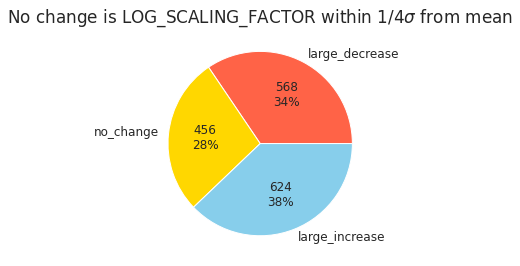

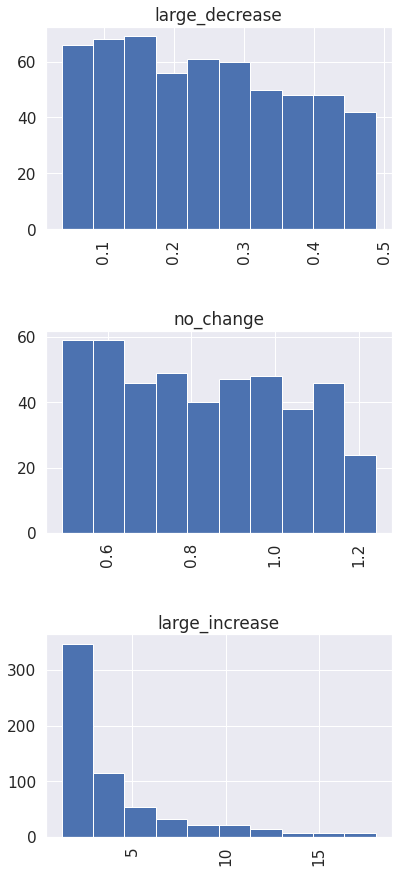

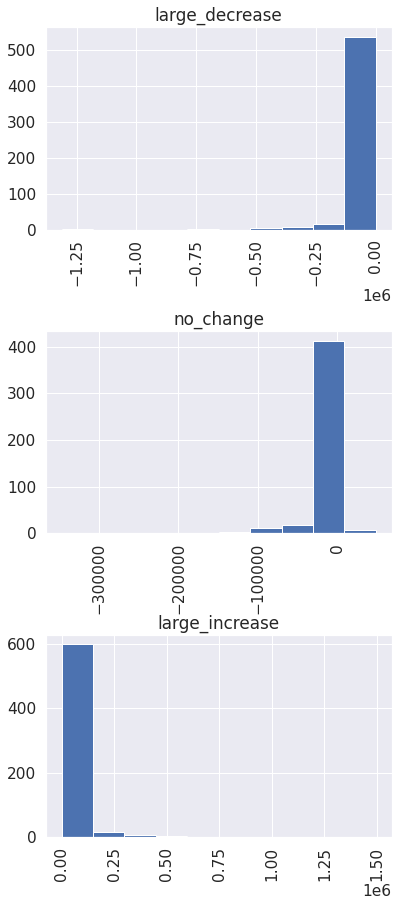

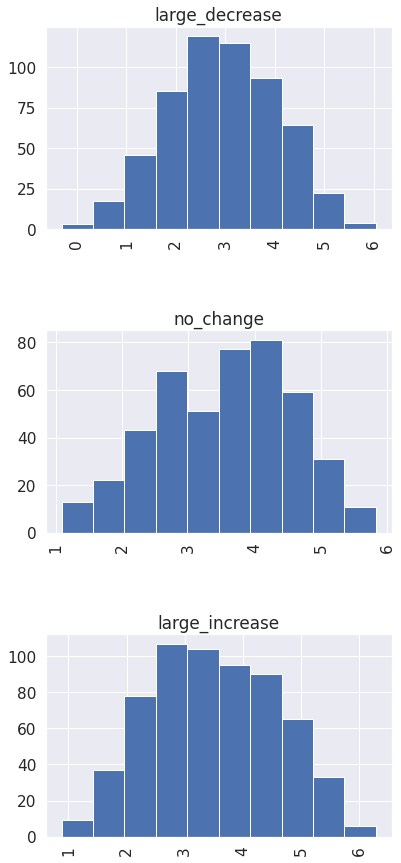

In [146]:
#SPLIT THE DATA INTO 3 CATEGORIES, 1/4 sigma
def label_function(val):
    return f'{val / 100 * len(features_no_outliers_weighted):.0f}\n{val:.0f}%'

#split the data!
rave_cat = pd.cut(features_no_outliers_weighted['Log_Scaling_Factor'].values, bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                  labels=['large_decrease','no_change','large_increase'])


features_no_outliers_weighted['change_category'] = rave_cat
print(features_no_outliers_weighted['change_category'])

features_no_outliers_weighted.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('No change is LOG_SCALING_FACTOR within 1/4$\sigma$ from mean')
plt.tight_layout()
plt.show()

# how are the scaling factors distributed in each caregory

"""features_no_outliers_weighted.groupby('change_category').plot(kind='hist',
                                  colors=['tomato', 'gold', 'skyblue'])"""

fig, axs = plt.subplots(3, 1, figsize=(6, 15))
features_no_outliers_weighted['Scaling_Factor'].hist(by=features_no_outliers_weighted['change_category'], ax=axs)
plt.show()

features_no_outliers_weighted['absolute_FRP_change'] = features_no_outliers_weighted['FRP_MEAN']-features_no_outliers_weighted['FRP_MEAN_1']
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
features_no_outliers_weighted['absolute_FRP_change'].hist(by=features_no_outliers_weighted['change_category'], ax=axs)
plt.show()


features_no_outliers_weighted['LOG_FRP_MEAN'] = np.log10(features_no_outliers_weighted['FRP_MEAN'])
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
features_no_outliers_weighted['LOG_FRP_MEAN'].hist(by=features_no_outliers_weighted['change_category'], ax=axs)
plt.show()

0            no_change
1       large_decrease
2            no_change
3       large_decrease
4       large_decrease
             ...      
1643    large_decrease
1644    large_decrease
1645    large_decrease
1646    large_decrease
1647    large_decrease
Name: change_category, Length: 1648, dtype: category
Categories (3, object): ['large_decrease' < 'no_change' < 'large_increase']


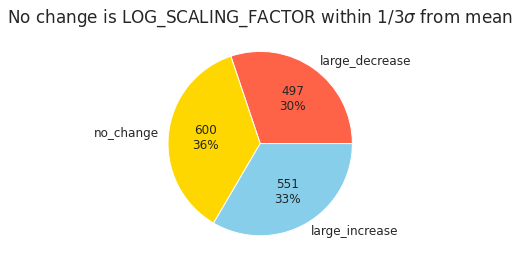

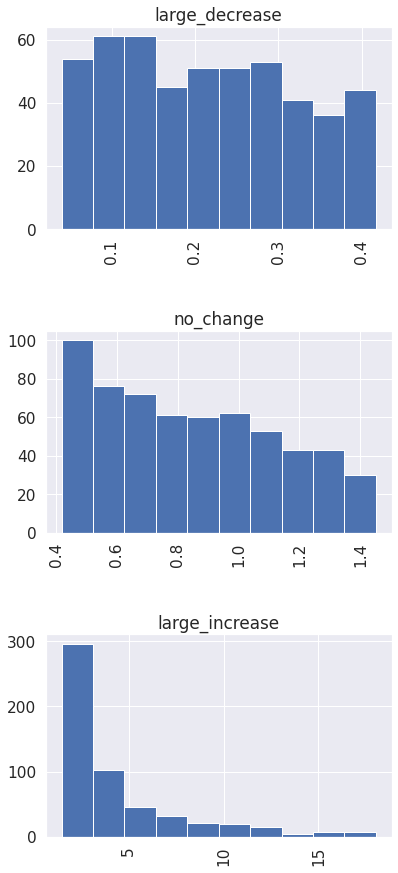

In [147]:
#SPLIT THE DATA INTO 3 CATEGORIES, 1/3 sigma
def label_function(val):
    return f'{val / 100 * len(features_no_outliers_weighted):.0f}\n{val:.0f}%'

#split the data!
rave_cat = pd.cut(features_no_outliers_weighted['Log_Scaling_Factor'].values, bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                  labels=['large_decrease','no_change','large_increase'])


features_no_outliers_weighted['change_category'] = rave_cat
print(features_no_outliers_weighted['change_category'])

features_no_outliers_weighted.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('No change is LOG_SCALING_FACTOR within 1/3$\sigma$ from mean')
plt.tight_layout()
plt.show()

# how are the scaling factors distributed in each caregory

"""features_no_outliers_weighted.groupby('change_category').plot(kind='hist',
                                  colors=['tomato', 'gold', 'skyblue'])"""

fig, axs = plt.subplots(3, 1, figsize=(6, 15))
features_no_outliers_weighted['Scaling_Factor'].hist(by=features_no_outliers_weighted['change_category'], ax=axs)
plt.show()


In [ ]:
#SPLIT THE DATA INTO 3 CATEGORIES
def label_function(val):
    return f'{val / 100 * len(features_no_outliers_weighted):.0f}\n{val:.0f}%'

#split the data!
rave_cat = pd.cut(features_no_outliers_weighted['Log_Scaling_Factor'].values, bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                  labels=['large_decrease','no_change','large_increase'])


features_no_outliers_weighted['change_category'] = rave_cat
print(features_no_outliers_weighted['change_category'])

features_no_outliers_weighted.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('No change is LOG_SCALING_FACTOR within .5$\sigma$ from mean')
plt.tight_layout()
plt.show()

In [ ]:
def REC_absolute(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def REC(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)/y_test)*100
    #percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,300, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

In [ ]:
# How does persistence do at capturing the varition over the three categories
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?

increase = features_no_outliers_weighted[features_no_outliers_weighted['change_category']=='large_increase']
decrease = features_no_outliers_weighted[features_no_outliers_weighted['change_category']=='large_decrease']
no_change = features_no_outliers_weighted[features_no_outliers_weighted['change_category']=='no_change']

print('Persistence performance for RMSE:')
print('for persistence large increases:  ' + str(RMSE(increase['persistence'], increase['Scaling_Factor'])))
print('for persistence no change: ' + str(RMSE(no_change['persistence'], no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(RMSE(decrease['persistence'], decrease['Scaling_Factor'])))
print()

print('Persistence performance for MAD:')
print('for persistence large increases:  ' + str(MAD(increase['persistence'], increase['Scaling_Factor'])))
print('for persistence no change: ' + str(MAD(no_change['persistence'], no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(MAD(decrease['persistence'], decrease['Scaling_Factor'])))
print()

print('Persistence performance for MeAD:')
print('for persistence large increases:  ' + str(MeAD(increase['persistence'], increase['Scaling_Factor'])))
print('for persistence no change: ' + str(MeAD(no_change['persistence'], no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(MeAD(decrease['persistence'], decrease['Scaling_Factor'])))
print()

thresh_persistence_no_change, acc_persistence_no_change = REC_absolute(no_change['persistence'], no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC_absolute(increase['persistence'], increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC_absolute(decrease['persistence'], decrease['Scaling_Factor'])


print('performance for AUC:')
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')

plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')

plt.legend(fontsize=15)
plt.title('REC Curve for Persistence (Under Different Error Types, zoom in)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xlim(-.25,2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

## Machine Learning

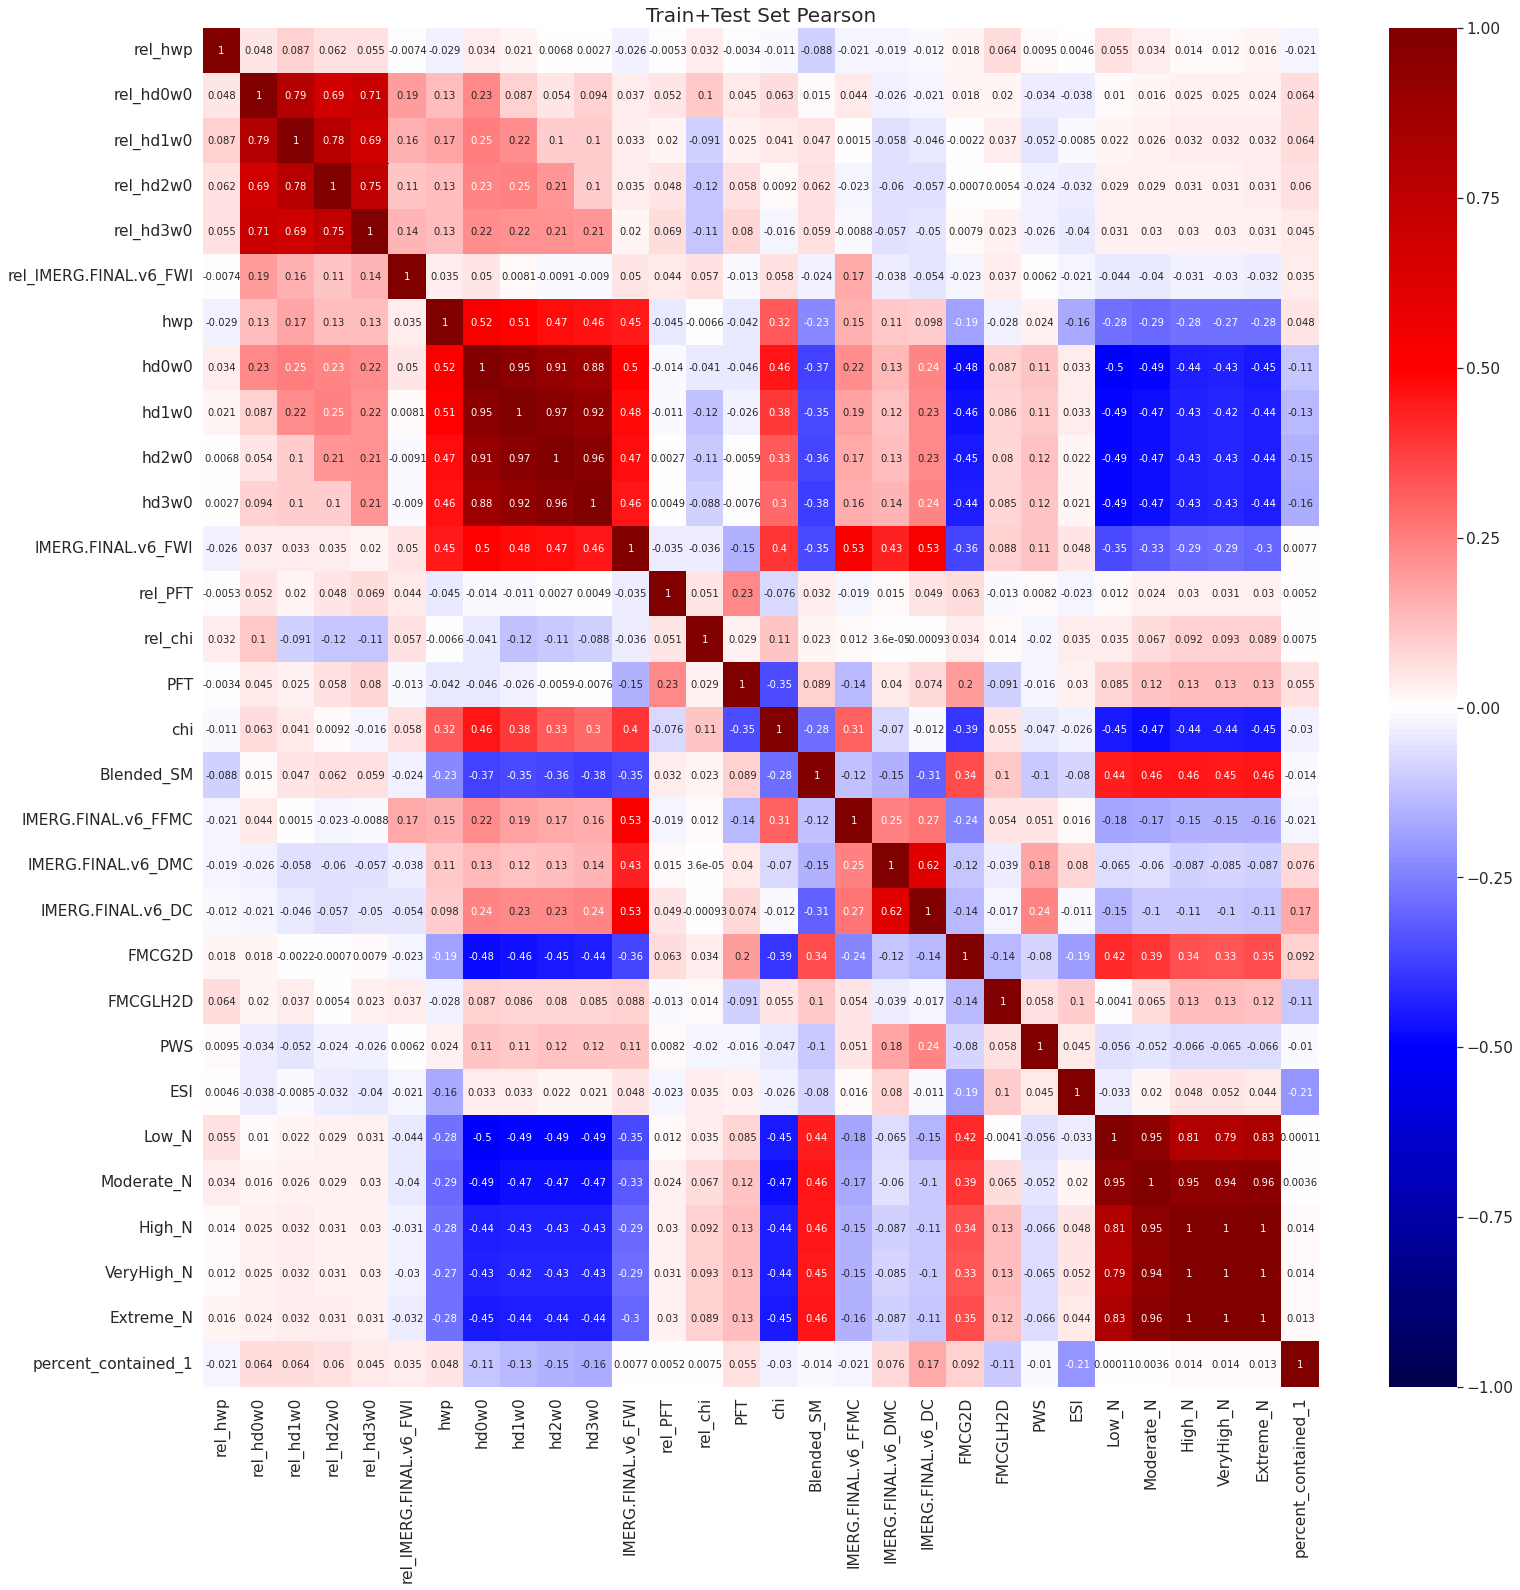

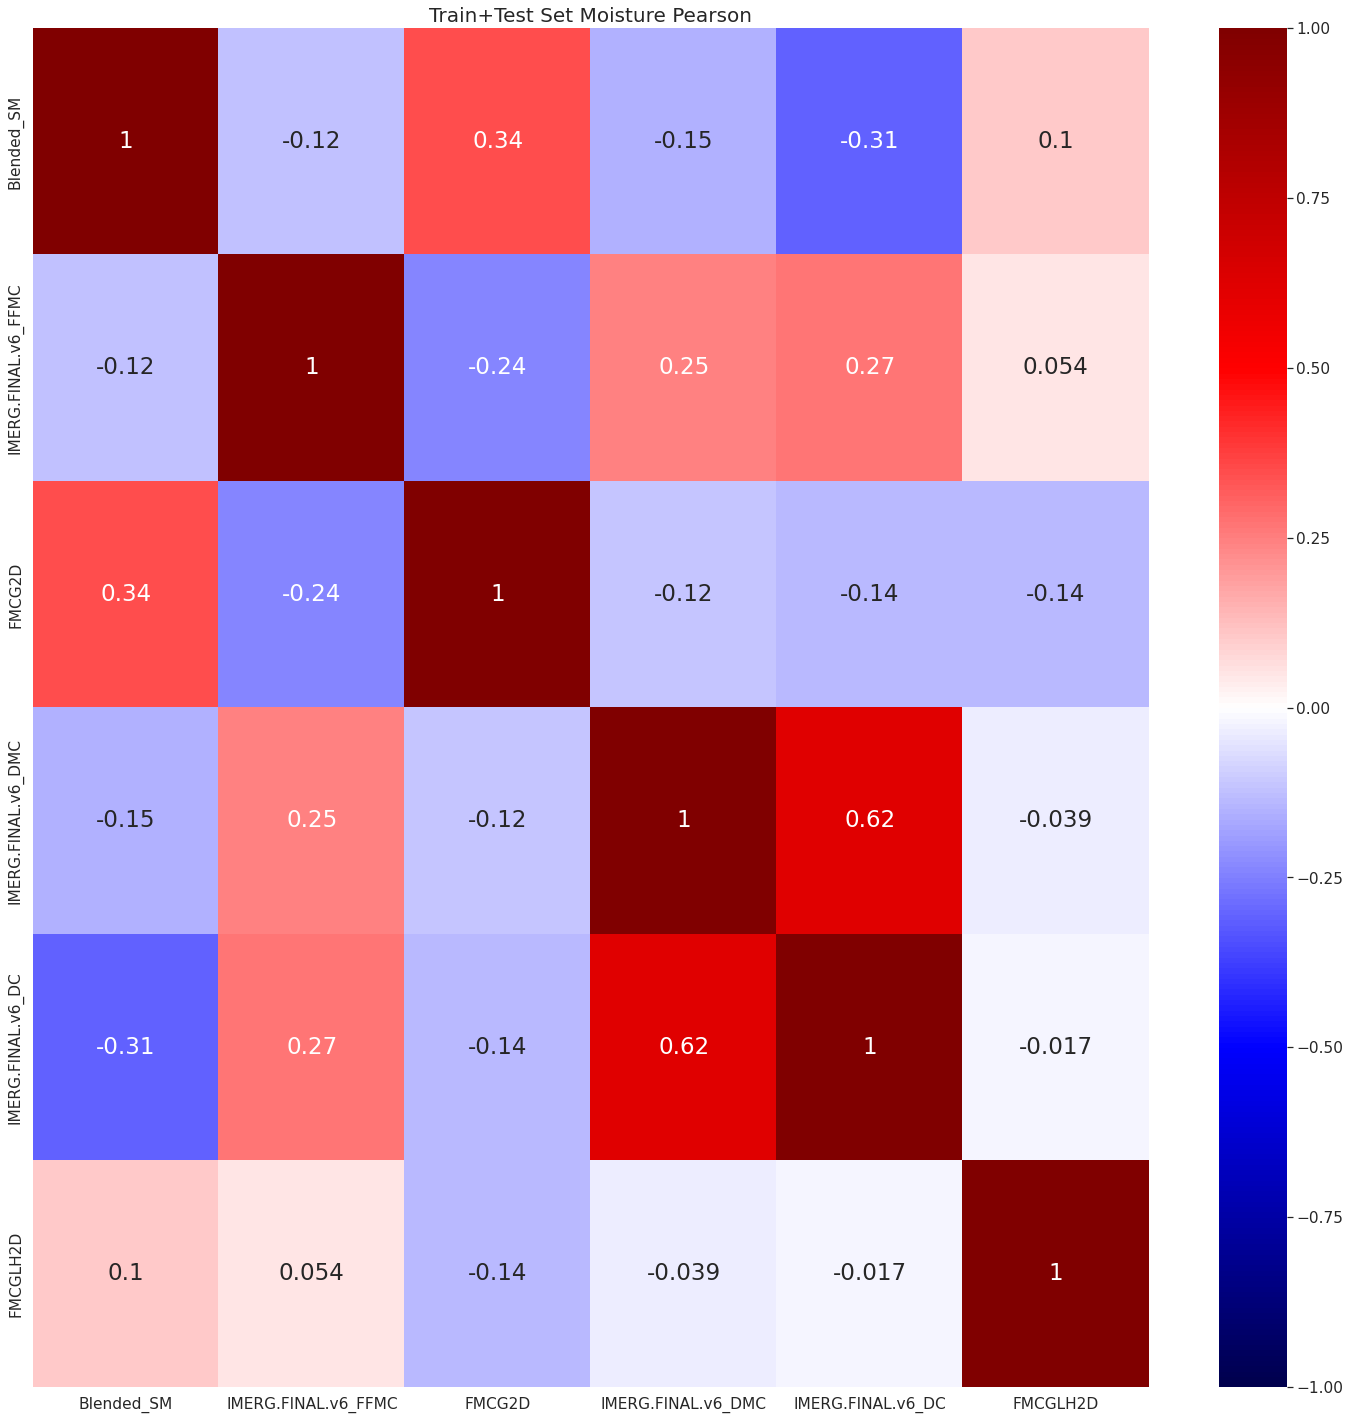

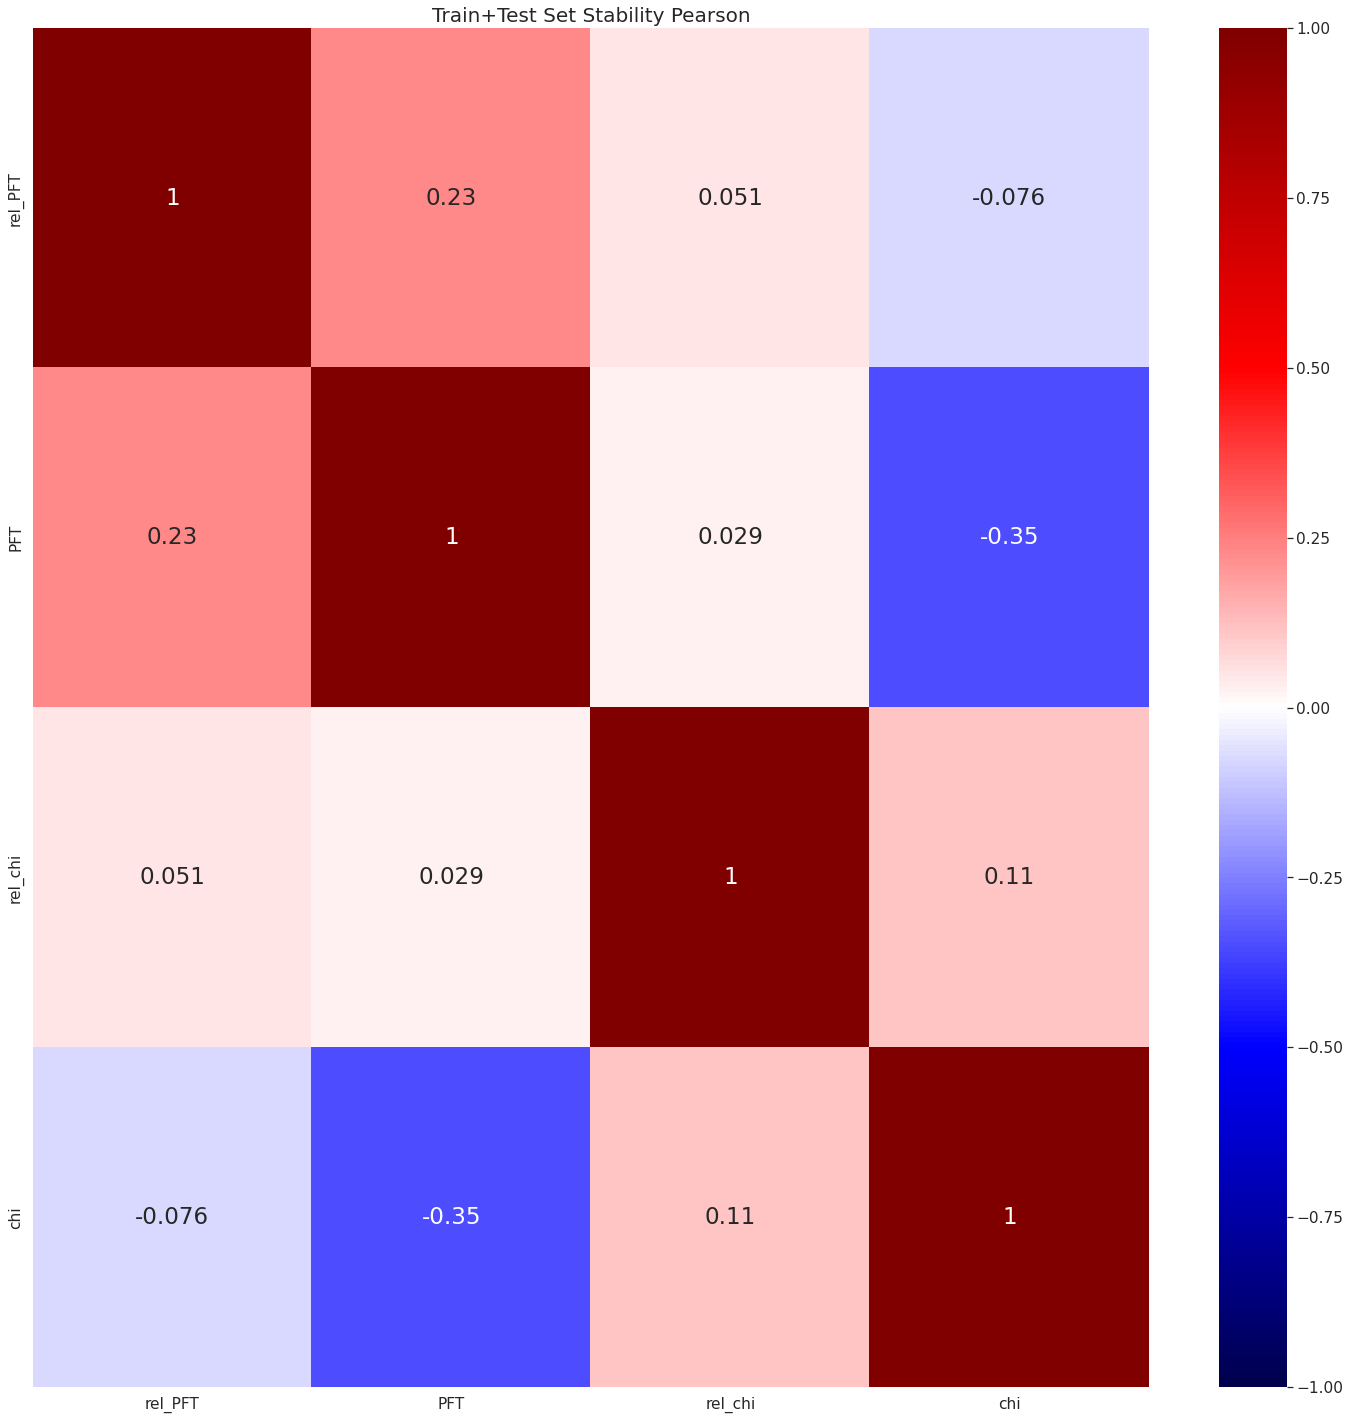

In [57]:
all_features=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi',
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

moisture_features= ['Blended_SM', 'IMERG.FINAL.v6_FFMC', 'FMCG2D','IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D']

stability_features= ['rel_PFT', 'PFT', 'rel_chi', 'chi']

plot_correlations(features_no_outliers_weighted[all_features], 'Train+Test Set Pearson','pearson', 10)
plot_correlations(features_no_outliers_weighted[moisture_features], 'Train+Test Set Moisture Pearson','pearson', 23)
plot_correlations(features_no_outliers_weighted[stability_features], 'Train+Test Set Stability Pearson','pearson', 23)


In [148]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]]
print(test_irwin_ids)

['EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA', '7D2A6B0A-A161-44D9-BFF1-6A68CEA947C5']


In [149]:
data_train = features_no_outliers_weighted.iloc[np.where(~features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_train), len(data_test), len(features_no_outliers_weighted))

1584 64 1648


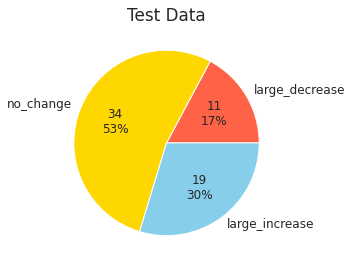

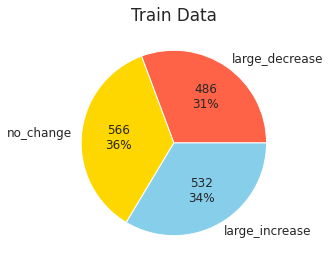

In [150]:
def label_function(val):
    return f'{val / 100 * len(data_test):.0f}\n{val:.0f}%'

data_test.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Test Data')
plt.tight_layout()
plt.show()


def label_function(val):
    return f'{val / 100 * len(data_train):.0f}\n{val:.0f}%'

data_train.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Train Data')
plt.tight_layout()
plt.show()

### Train models on a time series (3 days?) of FRP

In [151]:
training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1', 'FRP_MEAN_2'] #these will be the same for every forecast

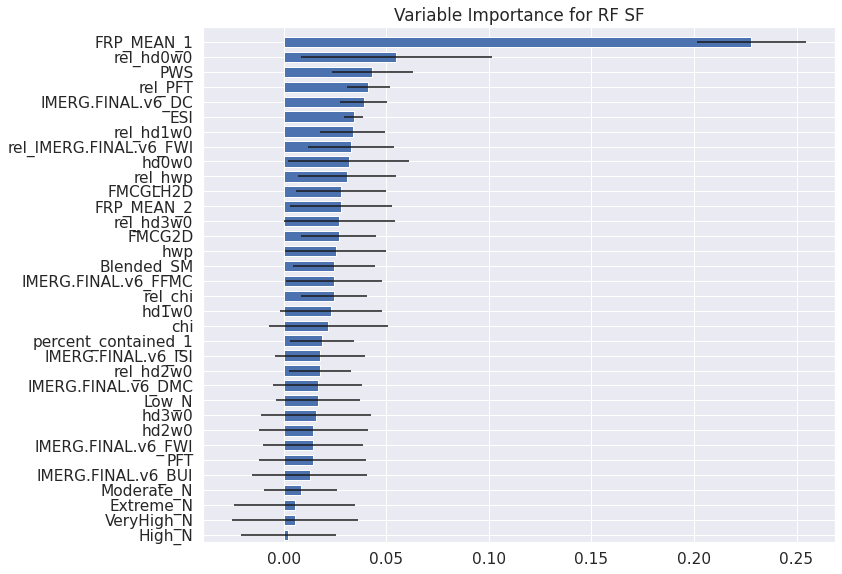

In [152]:
#define the random forests
rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables


#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['predicted_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['predicted_sf_frp'] = data_test['FRP_MEAN_1']*data_test['predicted_sf']
data_test['predicted_sf_category'] = pd.cut(np.log10(data_test['predicted_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

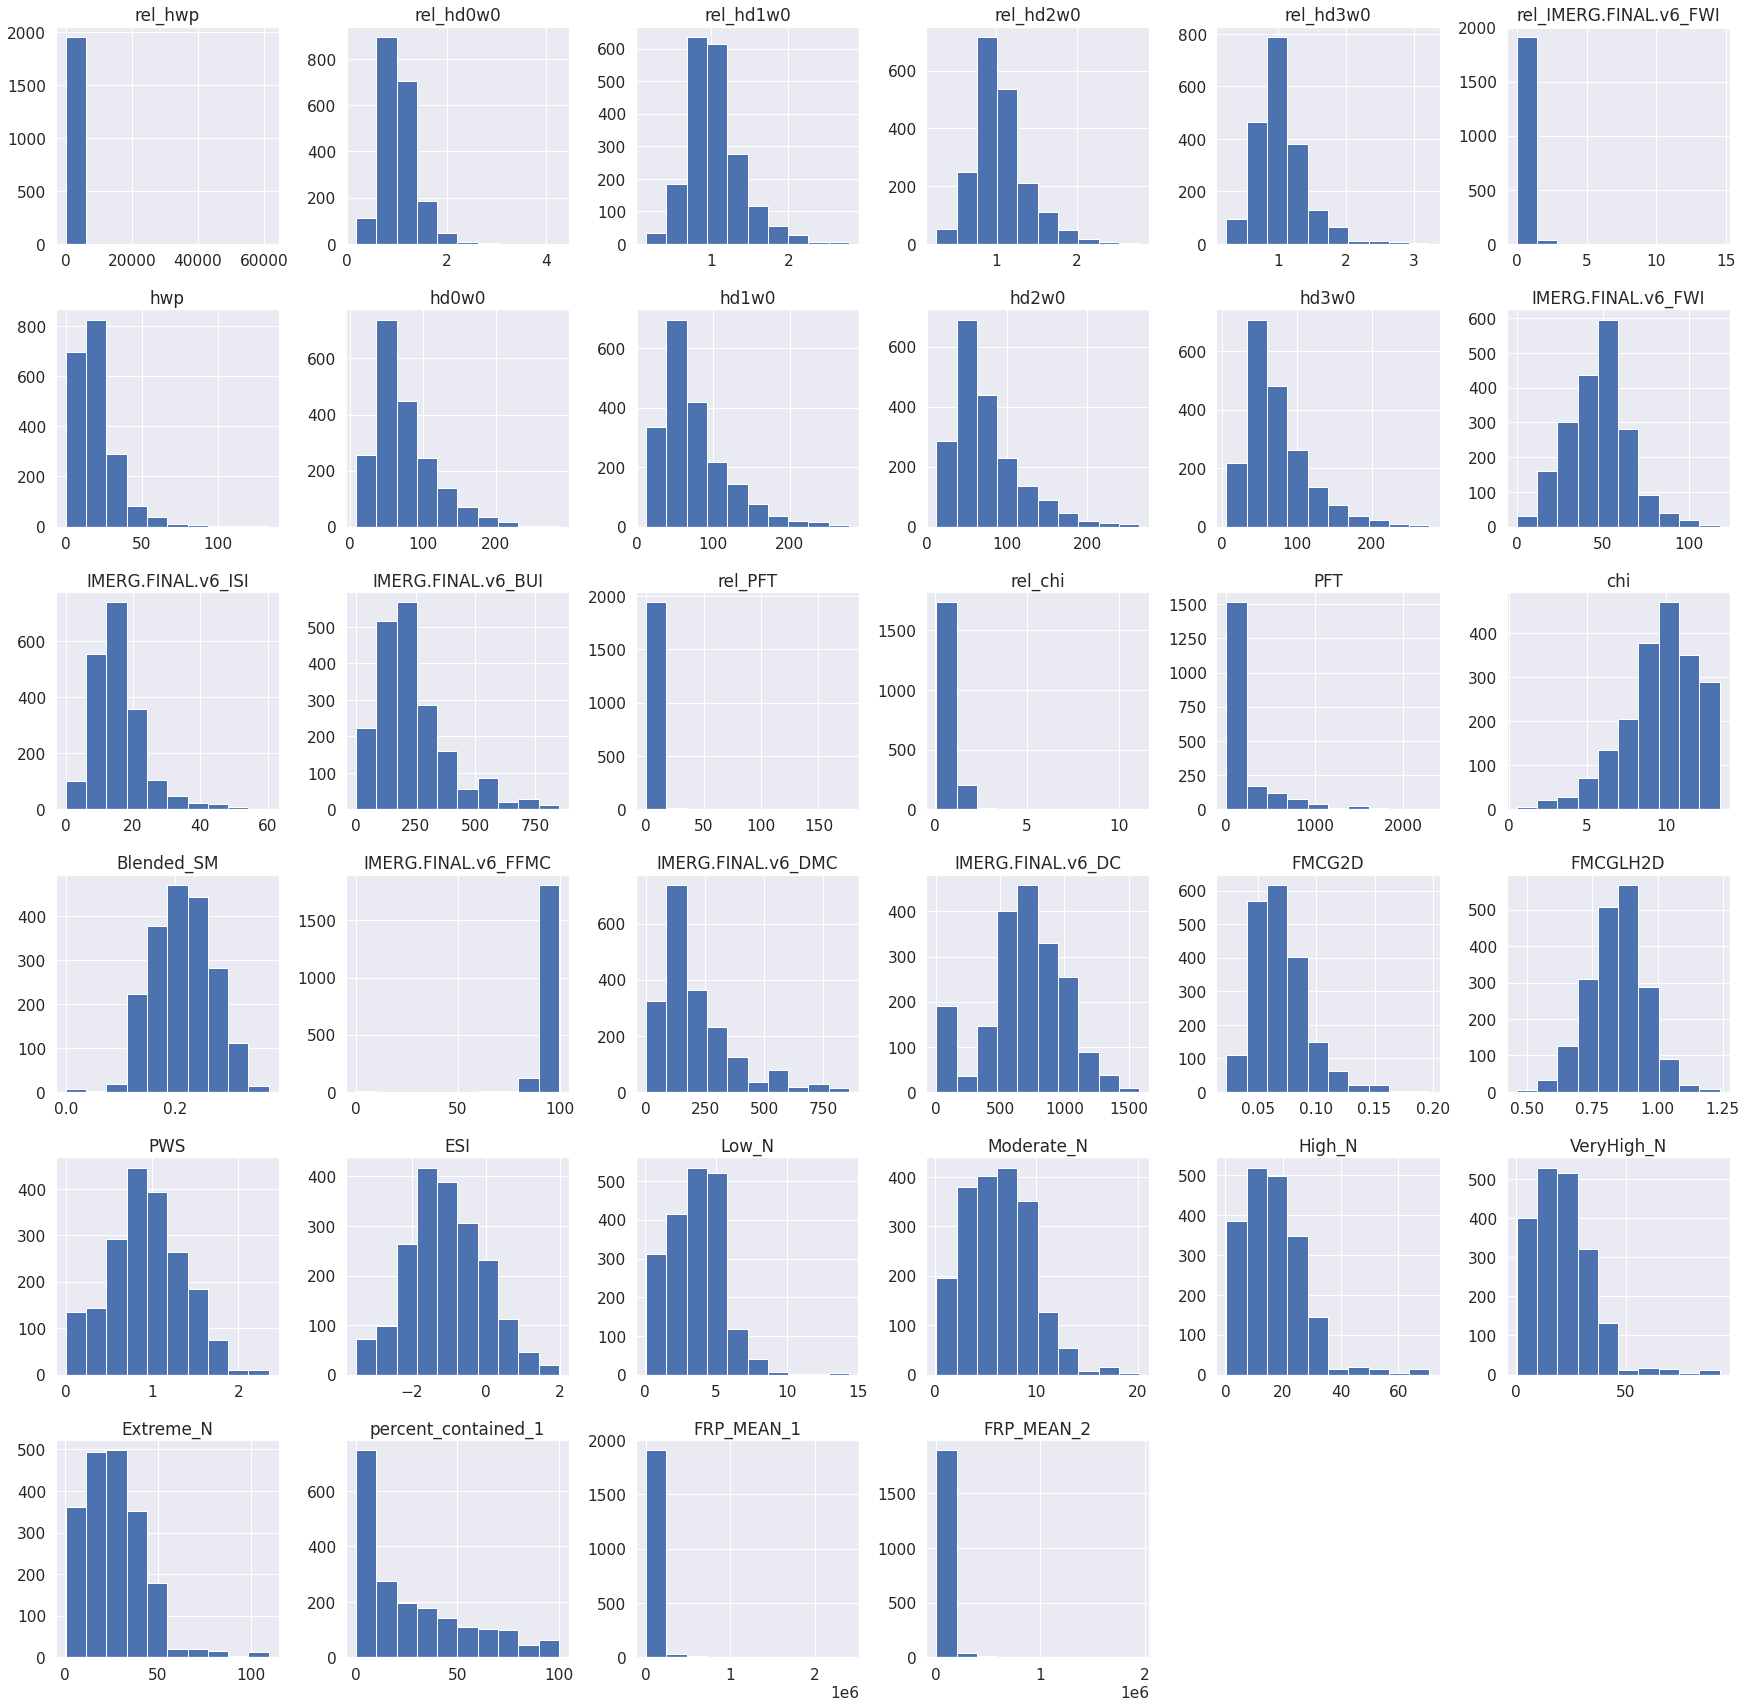

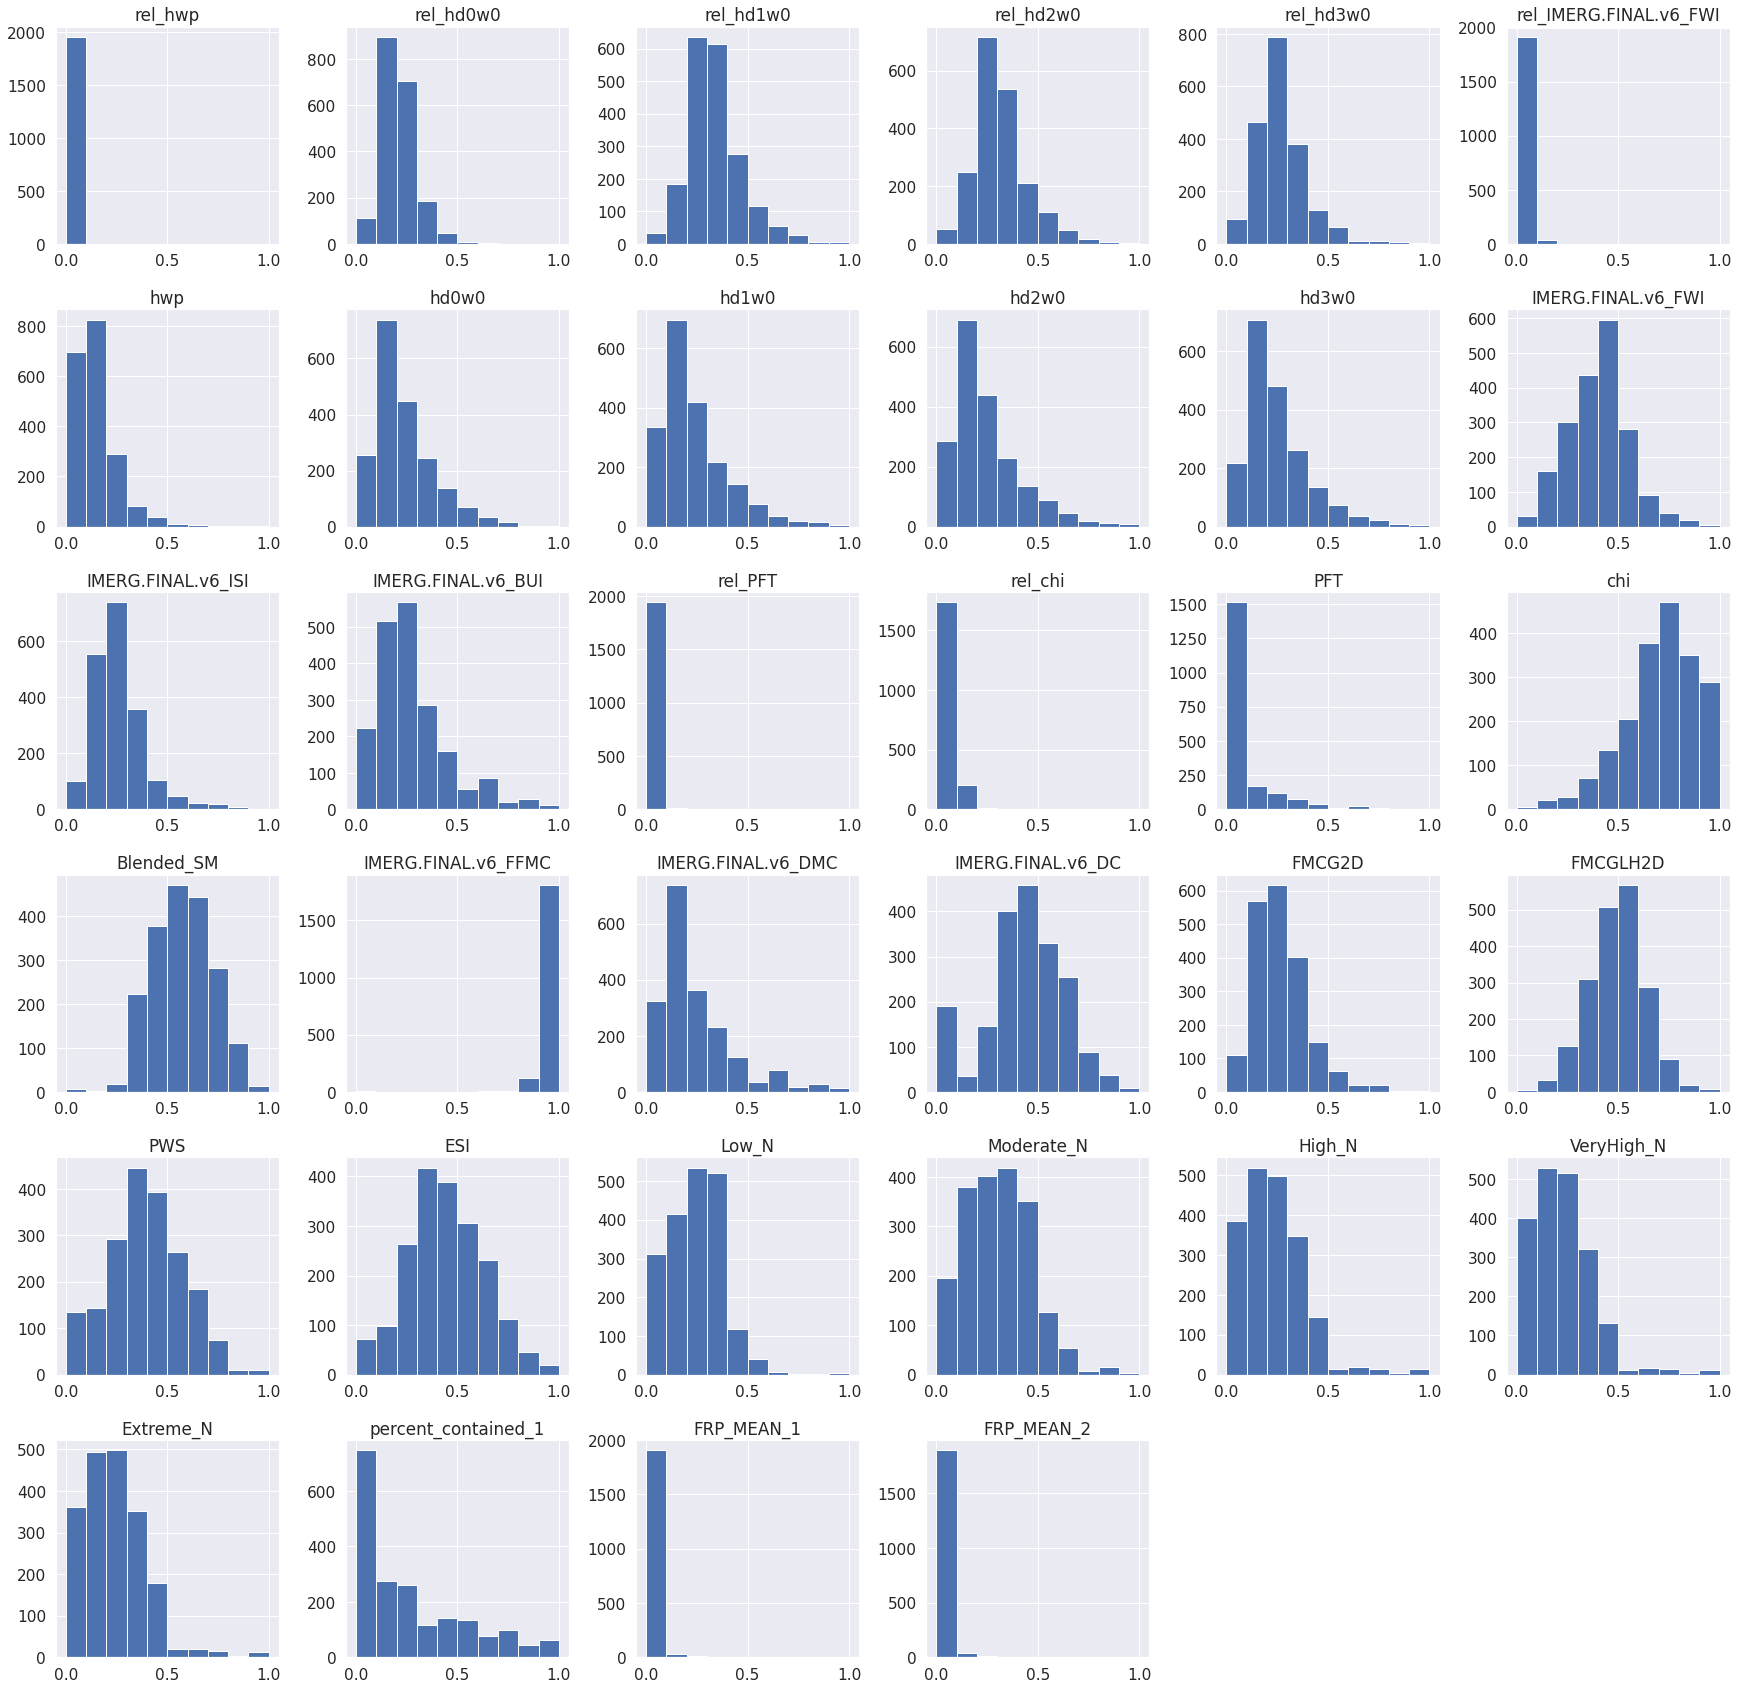

In [128]:
fig, ax = plt.subplots(figsize=(30,30))
features_no_outliers_weighted[training_variables].hist(ax=ax)
plt.show()

scaler = MinMaxScaler()


fig, ax = plt.subplots(figsize=(30,30))
scaled = pd.DataFrame(scaler.fit_transform(features_no_outliers_weighted[training_variables]),
                      columns = training_variables)
scaled.hist(ax=ax)
plt.show()


In [153]:
# train a neural network
regr = MLPRegressor(hidden_layer_sizes=10, random_state=42)
#scaler = StandardScaler()
scaler = MinMaxScaler()
#print(scaler.transform(data_train.loc[:, training_variables]))
regr.fit(scaler.fit_transform(data_train.loc[:, training_variables]), data_train.loc[:, 'Scaling_Factor'])
#regr.fit(scaler.fit_transform(data_train.loc[:, training_variables]), data_train.loc[:, 'FRP_MEAN'])


data_test['nn_pred_sf'] = regr.predict(scaler.fit_transform(data_test.loc[:,training_variables]))
print(data_test[['nn_pred_sf', 'Scaling_Factor']])

      nn_pred_sf  Scaling_Factor
686     3.412496        0.476561
687     2.868055        2.346032
688     4.369378        1.327415
689     3.867206        2.786815
690     0.568552        0.447159
...          ...             ...
1574    4.671228        7.432894
1575    3.116932        0.153407
1576    3.291235        1.115557
1577    2.140368        0.591467
1578    0.796247        0.054780

[64 rows x 2 columns]


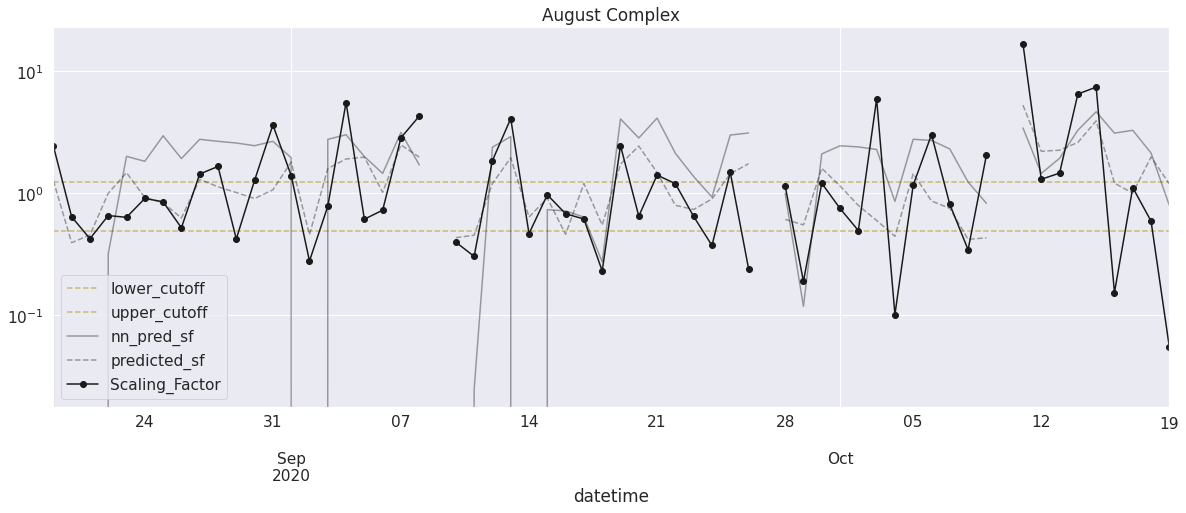

In [154]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['RF_FRP'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['nn_pred_sf'] # from the 3 separate RFs
data_composite_ac_plot['lower_cutoff'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff'] =10**(mu+(sigma/4))

data_test_ac_plot['predicted_sf_frp'] = data_test_ac_plot['FRP_MEAN_1']*data_test_ac_plot['predicted_sf'] 


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff', 'upper_cutoff'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf', 'predicted_sf'],style=['k-', 'k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['ko-'], ax=ax)
plt.yscale('log')
plt.title('August Complex')
plt.show()

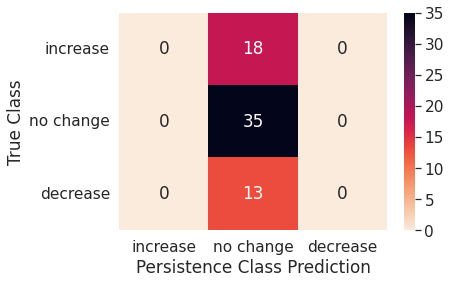

                precision    recall  f1-score   support

large_decrease       0.00      0.00      0.00        13
large_increase       0.00      0.00      0.00        18
     no_change       0.53      1.00      0.69        35

      accuracy                           0.53        66
     macro avg       0.18      0.33      0.23        66
  weighted avg       0.28      0.53      0.37        66



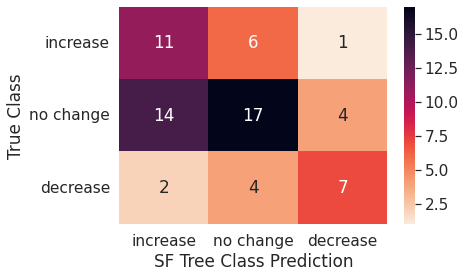

                precision    recall  f1-score   support

large_decrease       0.58      0.54      0.56        13
large_increase       0.41      0.61      0.49        18
     no_change       0.63      0.49      0.55        35

      accuracy                           0.53        66
     macro avg       0.54      0.55      0.53        66
  weighted avg       0.56      0.53      0.53        66



In [75]:
#how do different predictions agree with each other
conf_mat = confusion_matrix(data_test['change_category'], data_test['persistence_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('Persistence Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['persistence_change_category']))



conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF Tree Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['predicted_sf_category']))

In [155]:
#evaluate based on the OBSERVED change caregories!
data_eval_increase = data_test[data_test['change_category']=='large_increase']
data_eval_no_change = data_test[data_test['change_category']=='no_change']
data_eval_decrease = data_test[data_test['change_category']=='large_decrease']

performance for AUC:
for persistence for large increases:  711.5789473684213
for persistence for no change:  961.4705882352941
for persistence for large decreases:  919.090909090909
for ML (1RF predicting the scaling, all features+2days back FRP) large increases: 762.6315789473686
for ML (1RF predicting the scaling, all features+2days back FRP) no change: 954.1176470588234
for ML (1RF predicting the scaling, all features+2days back FRP) large decreases:  942.7272727272727
for ML (NN predicting the scaling, all features+2days back FRP) large increases: 802.1052631578949
for ML (NN predicting the scaling, all features+2days back FRP) no change: 862.6470588235294
for ML (NN predicting the scaling, all features+2days back FRP) large decreases:  895.4545454545455



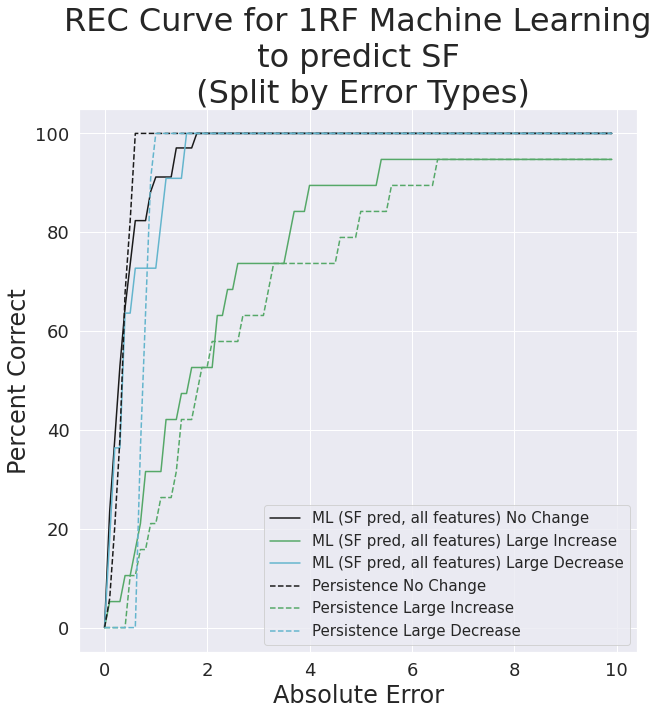

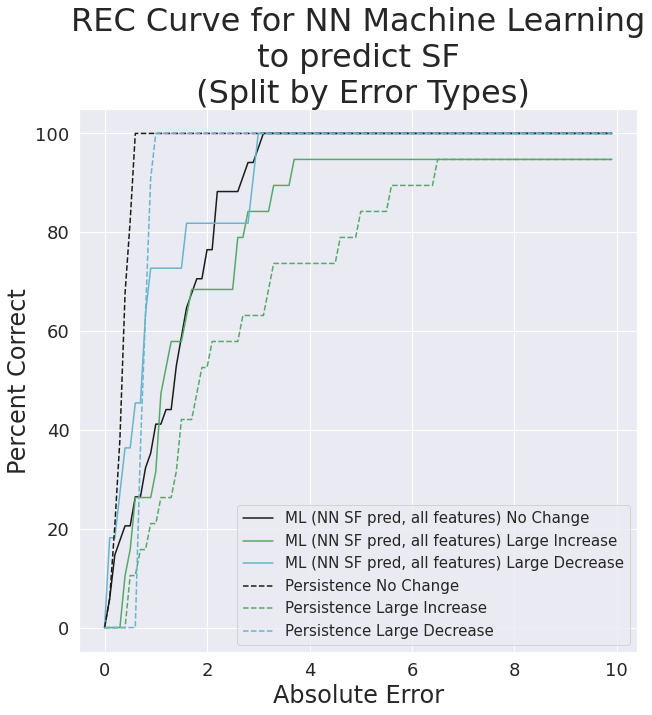

In [156]:
thresh_persistence_no_change, acc_persistence_no_change = REC(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])

thresh_rfsf_no_change, acc_rfsf_no_change = REC(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])
thresh_rfsf_increase, acc_rfsf_increase = REC(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])
thresh_rfsf_decrease, acc_rfsf_decrease = REC(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])

thresh_nnsf_no_change, acc_nnsf_no_change = REC(data_eval_no_change['nn_pred_sf'], data_eval_no_change['Scaling_Factor'])
thresh_nnsf_increase, acc_nnsf_increase = REC(data_eval_increase['nn_pred_sf'], data_eval_increase['Scaling_Factor'])
thresh_nnsf_decrease, acc_nnsf_decrease = REC(data_eval_decrease['nn_pred_sf'], data_eval_decrease['Scaling_Factor'])


print('performance for AUC:')
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))
print('for ML (1RF predicting the scaling, all features+2days back FRP) large increases: ' + str(AUC(acc_rfsf_increase)))
print('for ML (1RF predicting the scaling, all features+2days back FRP) no change: ' + str(AUC(acc_rfsf_no_change)))
print('for ML (1RF predicting the scaling, all features+2days back FRP) large decreases:  ' + str(AUC(acc_rfsf_decrease)))
print('for ML (NN predicting the scaling, all features+2days back FRP) large increases: ' + str(AUC(acc_nnsf_increase)))
print('for ML (NN predicting the scaling, all features+2days back FRP) no change: ' + str(AUC(acc_nnsf_no_change)))
print('for ML (NN predicting the scaling, all features+2days back FRP) large decreases:  ' + str(AUC(acc_nnsf_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_rfsf_no_change, 'k-',  label = 'ML (SF pred, all features) No Change')
plt.plot(thresh_rfsf_increase, acc_rfsf_increase, 'g-',  label = 'ML (SF pred, all features) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_rfsf_decrease, 'c-',  label = 'ML (SF pred, all features) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_nnsf_no_change, 'k-',  label = 'ML (NN SF pred, all features) No Change')
plt.plot(thresh_rfsf_increase, acc_nnsf_increase, 'g-',  label = 'ML (NN SF pred, all features) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_nnsf_decrease, 'c-',  label = 'ML (NN SF pred, all features) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for NN Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

performance for AUC:
for persistence:  880.0
for ML (1RF predicting the scaling): 895.3125
for ML (NN predicting the scaling): 850.3125



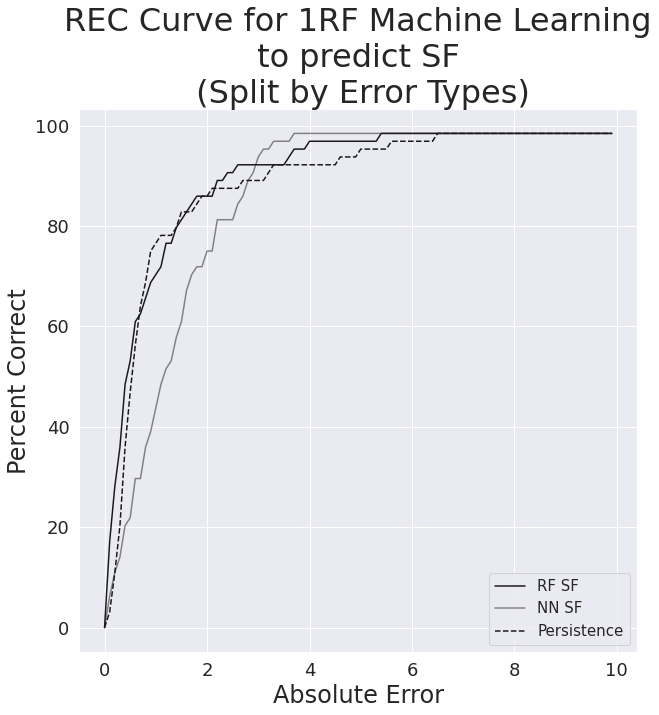

In [157]:
thresh_sf_composite, acc_sf_composite = REC(data_test['predicted_sf'], data_test['Scaling_Factor'])
thresh_nnsf_composite, acc_nnsf_composite = REC(data_test['nn_pred_sf'], data_test['Scaling_Factor'])

thresh_persistence_composite, acc_persistence_composite = REC(data_test['persistence'], data_test['Scaling_Factor'])




print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_persistence_composite)))
print('for ML (1RF predicting the scaling): ' + str(AUC(acc_sf_composite)))
print('for ML (NN predicting the scaling): ' + str(AUC(acc_nnsf_composite)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_sf_composite, acc_sf_composite, 'k-',  label = 'RF SF')
plt.plot(thresh_nnsf_composite, acc_nnsf_composite, 'k-', alpha=0.5,  label = 'NN SF')
plt.plot(thresh_persistence_composite, acc_persistence_composite, 'k--',  label = 'Persistence')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### What is the impact of non-met features?

In [ ]:
training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast

training_variables_met_only=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'FRP_MEAN_1'] #these will be the same for every forecast

In [ ]:
#define the random forests
rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_reg_sf_met_only = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables
rf_reg_sf_met_only.fit(data_train.loc[:, training_variables_met_only], data_train.loc[:, ['Scaling_Factor']]) #predict the scaling factor with met olny


#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['predicted_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['predicted_sf_frp'] = data_test['FRP_MEAN_1']*data_test['predicted_sf']
data_test['predicted_sf_category'] = pd.cut(np.log10(data_test['predicted_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories


data_test['predicted_sf_met_only'] = rf_reg_sf_met_only.predict(data_test.loc[:,training_variables_met_only])
data_test['predicted_sf_met_only_frp'] = data_test['FRP_MEAN_1']*data_test['predicted_sf_met_only']
data_test['predicted_sf_met_only_category'] = pd.cut(np.log10(data_test['predicted_sf_met_only'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])

In [ ]:
print(data_test['predicted_sf_met_only_category'])

In [ ]:
#how do different predictions agree with each other
conf_mat = confusion_matrix(data_test['change_category'], data_test['persistence_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('Persistence Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['persistence_change_category']))

conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_sf_met_only_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF (MET Only) Tree Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['predicted_sf_met_only_category']))



conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF Tree Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['predicted_sf_category']))

In [ ]:
#evaluate based on the OBSERVED change caregories!
data_eval_increase = data_test[data_test['change_category']=='large_increase']
data_eval_no_change = data_test[data_test['change_category']=='no_change']
data_eval_decrease = data_test[data_test['change_category']=='large_decrease']

In [ ]:
# compare scaling factors
# RF_SF is from the 3 RFS
# predicted_sf is what the single RF predicts for the Scaling Factor
# predicted_frp_sf is the scaling factor derived from the single RF which predicts FPR

print('ML performance for RMSE:')
print('for ML (1RF predicting the scaling, met only) large increases: ' + str(RMSE(data_eval_increase['predicted_sf_met_only'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, met only) no change: ' + str(RMSE(data_eval_no_change['predicted_sf_met_only'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, met only) large decreases:  ' + str(RMSE(data_eval_decrease['predicted_sf_met_only'], data_eval_decrease['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, all features) large increases: ' + str(RMSE(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, all features) no change: ' + str(RMSE(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, all features) large decreases:  ' + str(RMSE(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])))
print('for persistence large increases:  ' + str(RMSE(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])))
print('for persistence no change: ' + str(RMSE(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(RMSE(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])))
print()

print('ML performance for MAD:')
print('for ML (1RF predicting the scaling, met only) large increases: ' + str(MAD(data_eval_increase['predicted_sf_met_only'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, met only) no change: ' + str(MAD(data_eval_no_change['predicted_sf_met_only'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, met only) large decreases:  ' + str(MAD(data_eval_decrease['predicted_sf_met_only'], data_eval_decrease['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, all features) large increases: ' + str(MAD(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, all features) no change: ' + str(MAD(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the scaling, all features) large decreases:  ' + str(MAD(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])))
print('for persistence large increases:  ' + str(MAD(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])))
print('for persistence no change: ' + str(MAD(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(MAD(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])))
print()



In [ ]:


thresh_persistence_no_change, acc_persistence_no_change = REC(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])

thresh_rfsf_no_change, acc_rfsf_no_change = REC(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])
thresh_rfsf_increase, acc_rfsf_increase = REC(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])
thresh_rfsf_decrease, acc_rfsf_decrease = REC(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])

thresh_rffrp_no_change, acc_rffrp_no_change = REC(data_eval_no_change['predicted_sf_met_only'], data_eval_no_change['Scaling_Factor'])
thresh_rffrp_increase, acc_rffrp_increase = REC(data_eval_increase['predicted_sf_met_only'], data_eval_increase['Scaling_Factor'])
thresh_rffrp_decrease, acc_rffrp_decrease = REC(data_eval_decrease['predicted_sf_met_only'], data_eval_decrease['Scaling_Factor'])



print('performance for AUC:')
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))
print('for ML (1RF predicting the scaling, all features) large increases: ' + str(AUC(acc_rfsf_increase)))
print('for ML (1RF predicting the scaling, all features) no change: ' + str(AUC(acc_rfsf_no_change)))
print('for ML (1RF predicting the scaling, all features) large decreases:  ' + str(AUC(acc_rfsf_decrease)))
print('for ML (1RF predicting the scaling, met only) large increases: ' + str(AUC(acc_rffrp_increase)))
print('for ML (1RF predicting the scaling, met only) no change: ' + str(AUC(acc_rffrp_no_change)))
print('for ML (1RF predicting the scaling, met only) large decreases:  ' + str(AUC(acc_rffrp_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_rfsf_no_change, 'k-',  label = 'ML (SF pred, all features) No Change')
plt.plot(thresh_rfsf_increase, acc_rfsf_increase, 'g-',  label = 'ML (SF pred, all features) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_rfsf_decrease, 'c-',  label = 'ML (SF pred, all features) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rffrp_no_change, acc_rffrp_no_change, 'k-',  label = 'ML (FRP pred, met only) No Change')
plt.plot(thresh_rffrp_increase, acc_rffrp_increase, 'g-',  label = 'ML (FRP pred, met only) Large Increase')
plt.plot(thresh_rffrp_decrease, acc_rffrp_decrease, 'c-',  label = 'ML (FRP pred, met only) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict FRP \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()





### Compare RF that forecasts the category with RF that forecasts FRP and Scaling Factor
(compare their category forecasts)

In [ ]:
training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast

In [ ]:
#define the random forests
rf_class = RandomForestClassifier(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5,
                                 class_weight= 'balanced')
rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_reg_frp = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_class.fit(data_train.loc[:, training_variables], data_train.loc[:, ['change_category']])
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']])
rf_reg_frp.fit(data_train.loc[:, training_variables], data_train.loc[:, ['FRP_MEAN']])


#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['predicted_change_category'] = rf_class.predict(data_test.loc[:,training_variables])

data_test['predicted_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['predicted_sf_frp'] = data_test['FRP_MEAN_1']*data_test['predicted_sf']
data_test['predicted_sf_category'] = pd.cut(np.log10(data_test['predicted_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories

data_test['predicted_frp'] = rf_reg_frp.predict(data_test.loc[:,training_variables])
data_test['predicted_frp_sf'] = data_test['predicted_frp']/data_test['FRP_MEAN_1'] #transform predicted FRP into a scaling factor
data_test['predicted_frp_sf_category'] = pd.cut(np.log10(data_test['predicted_frp_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories

In [ ]:
plot_importances(rf_reg_sf, training_variables,'Variable Importance for RF SF')
#plot_importances(rf_reg_frp, training_variables,'Variable Importance for RF FRP')

In [ ]:
#plot a time series of the change category
data_test_wf = data_test[data_test['irwinID']==test_irwin_ids[1]]
data_test_wf[['datetime','change_category', 'predicted_change_category', 'predicted_sf_category']]

In [ ]:
#plot a time series of the change category
data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac[['datetime','change_category', 'predicted_change_category', 'predicted_sf_category', 'predicted_frp_sf_category']]

In [ ]:
#how do different predictions agree with each other
conf_mat = confusion_matrix(data_test['predicted_change_category'], data_test['predicted_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF Tree Class Prediction')
plt.ylabel('Classification Tree Class Prediction')
plt.show()

conf_mat = confusion_matrix(data_test['predicted_change_category'], data_test['predicted_frp_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('FRP Tree Class Prediction')
plt.ylabel('Classification Tree Class Prediction')
plt.show()


conf_mat = confusion_matrix(data_test['predicted_sf_category'], data_test['predicted_frp_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('FRP Tree Class Prediction')
plt.ylabel('SF Tree Class Prediction')
plt.show()

In [ ]:
# plot heatmaps
conf_mat = confusion_matrix(data_test['change_category'], data_test['persistence_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Persistence, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()

#classification_report(y_true, y_pred)
print(classification_report(data_test['change_category'], data_test['persistence_change_category']))

In [ ]:
# plot heatmaps
#confusion_matrix(y_true, y_pred)
conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Classification Forest Full Feature Set, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()

#classification_report(y_true, y_pred)
print(classification_report(data_test['change_category'], data_test['predicted_change_category']))

#do it by fire

#august complex
data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
conf_mat = confusion_matrix(data_test_ac['change_category'], data_test_ac['predicted_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Classification Forest Full Feature Set, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()
#classification_report(y_true, y_pred)
print(classification_report(data_test_ac['change_category'], data_test_ac['predicted_change_category']))

#williams flats
data_test_wf = data_test[data_test['irwinID']==test_irwin_ids[1]]
conf_mat = confusion_matrix(data_test_wf['change_category'], data_test_wf['predicted_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Classification Forest Full Feature Set, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()
#classification_report(y_true, y_pred)
print(classification_report(data_test_wf['change_category'], data_test_wf['predicted_change_category']))

In [ ]:
# plot heatmaps
conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Regression Forest SF prediction Full Feature Set, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()

#classification_report(y_true, y_pred)
print(classification_report(data_test['change_category'], data_test['predicted_sf_category']))


#williams flats
data_test_wf = data_test[data_test['irwinID']==test_irwin_ids[1]]
conf_mat = confusion_matrix(data_test_wf['change_category'], data_test_wf['predicted_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Regression Forest SF Prediction Full Feature Set, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()
#classification_report(y_true, y_pred)
print(classification_report(data_test_wf['change_category'], data_test_wf['predicted_sf_category']))

In [ ]:
# plot heatmaps
conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_frp_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Regression Forest FRP prediction Full Feature Set, 1/4 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()

#classification_report(y_true, y_pred)
print(classification_report(data_test['change_category'], data_test['predicted_frp_sf_category']))

In [ ]:
print(data_test.columns.values)

In [ ]:
#use the RF-predicted INCREASES

data_train_increase = data_train[data_train['change_category']=='large_increase']
data_test_increase = data_test[data_test['predicted_change_category']=='large_increase']

print(len(data_train_increase), len(data_test_increase))

# Train with the full feature set
rf_increase = RandomForestRegressor(oob_score=True,min_samples_leaf=5,n_estimators=100, random_state=42) #scaling is not necessary!
rf_increase.fit(data_train_increase.loc[:, training_variables], data_train_increase.loc[:, ['Scaling_Factor']])

data_test_increase['RF_SF'] = rf_increase.predict(data_test_increase.loc[:,training_variables])

#plot_importances(rf_increase, training_variables,'Increase RF')


#scatter_plot(data_test_increase,'Scaling_Factor','RF_SF','irwinID', None, None, None,'plot_title')


In [ ]:
#use the RF-predicted class
data_train_decrease = data_train[data_train['change_category']=='large_decrease']
data_test_decrease = data_test[data_test['predicted_change_category']=='large_decrease']

print(len(data_train_decrease), len(data_test_decrease))


#train with the full feature set
rf_decrease = RandomForestRegressor(oob_score=True,min_samples_leaf=5,n_estimators=100, random_state=42) #scaling is not necessary!
rf_decrease.fit(data_train_decrease.loc[:, training_variables], data_train_decrease.loc[:, ['Scaling_Factor']])


data_test_decrease['RF_SF'] = rf_decrease.predict(data_test_decrease.loc[:,training_variables])
#plot_importances(rf_decrease, training_variables,'Decrease RF')



In [ ]:
#use the RF-predicted class
data_train_no_change = data_train[data_train['change_category']=='no_change']
data_test_no_change = data_test[data_test['predicted_change_category']=='no_change']

print(len(data_train_no_change), len(data_test_no_change))

#train with the full feature set
rf_no_change = RandomForestRegressor(oob_score=True,min_samples_leaf=5,n_estimators=100, random_state=42) #scaling is not necessary!
rf_no_change.fit(data_train_no_change.loc[:, training_variables], data_train_no_change.loc[:, ['Scaling_Factor']])

data_test_no_change['RF_SF'] = rf_no_change.predict(data_test_no_change.loc[:,training_variables])


#plot_importances(rf_no_change, training_variables,'no_change RF')


#print(data_test_increase[['irwinID','datetime','Scaling_Factor', 'RF_SF']])

#scatter_plot(data_test_no_change,'Scaling_Factor','RF_SF','irwinID', None, None, None,'plot_title')


In [ ]:
data_test_composite = pd.concat([data_test_no_change, data_test_increase, data_test_decrease],
                               axis=0).reset_index(drop=True) # a combination of the outputs from the three forecasts
data_test_composite = data_test_composite.sort_values(by='datetime', axis=0).reset_index(drop=True)
data_test_composite['RF_FRP'] = data_test_composite['FRP_MEAN_1']*data_test_composite['RF_SF'] # from the 3 separate RFs
data_test_composite['predicted_sf_frp'] = data_test_composite['FRP_MEAN_1']*data_test_composite['predicted_sf'] 


#evaluate based on the OBSERVED change caregories!
data_eval_increase = data_test_composite[data_test_composite['change_category']=='large_increase']
data_eval_no_change = data_test_composite[data_test_composite['change_category']=='no_change']
data_eval_decrease = data_test_composite[data_test_composite['change_category']=='large_decrease']

In [ ]:
# compare scaling factors
# RF_SF is from the 3 RFS
# predicted_sf is what the single RF predicts for the Scaling Factor
# predicted_frp_sf is the scaling factor derived from the single RF which predicts FPR

print('ML performance for RMSE:')
print('for ML (3RF) large increases: ' + str(RMSE(data_eval_increase['RF_SF'], data_eval_increase['Scaling_Factor'])))
print('for ML (3RF) no change: ' + str(RMSE(data_eval_no_change['RF_SF'], data_eval_no_change['Scaling_Factor'])))
print('for ML (3RF) large decreases:  ' + str(RMSE(data_eval_decrease['RF_SF'], data_eval_decrease['Scaling_Factor'])))
print('for ML (1RF predicting the scaling) large increases: ' + str(RMSE(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the scaling) no change: ' + str(RMSE(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the scaling) large decreases:  ' + str(RMSE(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])))
print('for ML (1RF predicting the FRP) large increases: ' + str(RMSE(data_eval_increase['predicted_frp_sf'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the FRP) no change: ' + str(RMSE(data_eval_no_change['predicted_frp_sf'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the FRP) large decreases:  ' + str(RMSE(data_eval_decrease['predicted_frp_sf'], data_eval_decrease['Scaling_Factor'])))
print('for persistence large increases:  ' + str(RMSE(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])))
print('for persistence no change: ' + str(RMSE(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(RMSE(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])))
print()

print('ML performance for MAD:')
print('for ML (3RF) large increases: ' + str(MAD(data_eval_increase['RF_SF'], data_eval_increase['Scaling_Factor'])))
print('for ML (3RF) no change: ' + str(MAD(data_eval_no_change['RF_SF'], data_eval_no_change['Scaling_Factor'])))
print('for ML (3RF) large decreases:  ' + str(MAD(data_eval_decrease['RF_SF'], data_eval_decrease['Scaling_Factor'])))
print('for ML (1RF predicting the scaling) large increases: ' + str(MAD(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the scaling) no change: ' + str(MAD(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the scaling) large decreases:  ' + str(MAD(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])))
print('for ML (1RF predicting the FRP) large increases: ' + str(MAD(data_eval_increase['predicted_frp_sf'], data_eval_increase['Scaling_Factor'])))
print('for ML (1RF predicting the FRP) no change: ' + str(MAD(data_eval_no_change['predicted_frp_sf'], data_eval_no_change['Scaling_Factor'])))
print('for ML (1RF predicting the FRP) large decreases:  ' + str(MAD(data_eval_decrease['predicted_frp_sf'], data_eval_decrease['Scaling_Factor'])))
print('for persistence large increases:  ' + str(MAD(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])))
print('for persistence no change: ' + str(MAD(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(MAD(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])))
print()

In [ ]:
thresh_no_change, acc_no_change = REC(data_eval_no_change['RF_SF'], data_eval_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(data_eval_increase['RF_SF'], data_eval_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(data_eval_decrease['RF_SF'], data_eval_decrease['Scaling_Factor'])

thresh_persistence_no_change, acc_persistence_no_change = REC(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])

thresh_rfsf_no_change, acc_rfsf_no_change = REC(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])
thresh_rfsf_increase, acc_rfsf_increase = REC(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])
thresh_rfsf_decrease, acc_rfsf_decrease = REC(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])

thresh_rffrp_no_change, acc_rffrp_no_change = REC(data_eval_no_change['predicted_frp_sf'], data_eval_no_change['Scaling_Factor'])
thresh_rffrp_increase, acc_rffrp_increase = REC(data_eval_increase['predicted_frp_sf'], data_eval_increase['Scaling_Factor'])
thresh_rffrp_decrease, acc_rffrp_decrease = REC(data_eval_decrease['predicted_frp_sf'], data_eval_decrease['Scaling_Factor'])



print('performance for AUC:')
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))
print('for ML (3RF) large increases: ' + str(AUC(acc_increase)))
print('for ML (3RF) no change: ' + str(AUC(acc_no_change)))
print('for ML (3RF) large decreases:  ' + str(AUC(acc_decrease)))
print('for ML (1RF predicting the scaling) large increases: ' + str(AUC(acc_rfsf_increase)))
print('for ML (1RF predicting the scaling) no change: ' + str(AUC(acc_rfsf_no_change)))
print('for ML (1RF predicting the scaling) large decreases:  ' + str(AUC(acc_rfsf_decrease)))
print('for ML (1RF predicting the frp) large increases: ' + str(AUC(acc_rffrp_increase)))
print('for ML (1RF predicting the frp) no change: ' + str(AUC(acc_rffrp_no_change)))
print('for ML (1RF predicting the frp) large decreases:  ' + str(AUC(acc_rffrp_decrease)))
print()

plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'ML (3RF) No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'ML (3RF) Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'ML (3RF) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 3RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_rfsf_no_change, 'k-',  label = 'ML (SF pred) No Change')
plt.plot(thresh_rfsf_increase, acc_rfsf_increase, 'g-',  label = 'ML (SF pred) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_rfsf_decrease, 'c-',  label = 'ML (SF pred) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rffrp_no_change, acc_rffrp_no_change, 'k-',  label = 'ML (FRP pred) No Change')
plt.plot(thresh_rffrp_increase, acc_rffrp_increase, 'g-',  label = 'ML (FRP pred) Large Increase')
plt.plot(thresh_rffrp_decrease, acc_rffrp_decrease, 'c-',  label = 'ML (FRP pred) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict FRP \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()





In [ ]:
thresh_sf_composite, acc_sf_composite = REC(data_test['predicted_sf'], data_test['Scaling_Factor'])
thresh_persistence_composite, acc_persistence_composite = REC(data_test['persistence'], data_test['Scaling_Factor'])




print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_persistence_composite)))
print('for ML (1RF predicting the scaling): ' + str(AUC(acc_sf_composite)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_sf_composite, acc_sf_composite, 'k-',  label = 'ML SF')
plt.plot(thresh_persistence_composite, acc_persistence_composite, 'k--',  label = 'Persistence No Change')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()







In [ ]:
# compare FRP
# RF_FRP is from the 3 RFS
# predicted_sf_frp is what the single RF predicts for the Scaling Factor
# predicted_frp is the scaling factor derived from the single RF which predicts FPR

print('ML performance for RMSE:')
print('for ML (3RF) large increases: ' + str(RMSE(data_eval_increase['RF_FRP'], data_eval_increase['FRP_MEAN'])))
print('for ML (3RF) no change: ' + str(RMSE(data_eval_no_change['RF_FRP'], data_eval_no_change['FRP_MEAN'])))
print('for ML (3RF) large decreases:  ' + str(RMSE(data_eval_decrease['RF_FRP'], data_eval_decrease['FRP_MEAN'])))
print('for ML (1RF predicting the scaling) large increases: ' + str(RMSE(data_eval_increase['predicted_sf_frp'], data_eval_increase['FRP_MEAN'])))
print('for ML (1RF predicting the scaling) no change: ' + str(RMSE(data_eval_no_change['predicted_sf_frp'], data_eval_no_change['FRP_MEAN'])))
print('for ML (1RF predicting the scaling) large decreases:  ' + str(RMSE(data_eval_decrease['predicted_sf_frp'], data_eval_decrease['FRP_MEAN'])))
print('for ML (1RF predicting the FRP) large increases: ' + str(RMSE(data_eval_increase['predicted_frp'], data_eval_increase['FRP_MEAN'])))
print('for ML (1RF predicting the FRP) no change: ' + str(RMSE(data_eval_no_change['predicted_frp'], data_eval_no_change['FRP_MEAN'])))
print('for ML (1RF predicting the FRP) large decreases:  ' + str(RMSE(data_eval_decrease['predicted_frp'], data_eval_decrease['FRP_MEAN'])))
print('for persistence large increases:  ' + str(RMSE(data_eval_increase['FRP_MEAN_1'], data_eval_increase['FRP_MEAN'])))
print('for persistence no change: ' + str(RMSE(data_eval_no_change['FRP_MEAN_1'], data_eval_no_change['FRP_MEAN'])))
print('for persistence large decreases:  ' + str(RMSE(data_eval_decrease['FRP_MEAN_1'], data_eval_decrease['FRP_MEAN'])))
print()

print('ML performance for MAD:')
print('for ML (3RF) large increases: ' + str(MAD(data_eval_increase['RF_FRP'], data_eval_increase['FRP_MEAN'])))
print('for ML (3RF) no change: ' + str(MAD(data_eval_no_change['RF_FRP'], data_eval_no_change['FRP_MEAN'])))
print('for ML (3RF) large decreases:  ' + str(MAD(data_eval_decrease['RF_FRP'], data_eval_decrease['FRP_MEAN'])))
print('for ML (1RF predicting the scaling) large increases: ' + str(MAD(data_eval_increase['predicted_sf_frp'], data_eval_increase['FRP_MEAN'])))
print('for ML (1RF predicting the scaling) no change: ' + str(MAD(data_eval_no_change['predicted_sf_frp'], data_eval_no_change['FRP_MEAN'])))
print('for ML (1RF predicting the scaling) large decreases:  ' + str(MAD(data_eval_decrease['predicted_sf_frp'], data_eval_decrease['FRP_MEAN'])))
print('for ML (1RF predicting the FRP) large increases: ' + str(MAD(data_eval_increase['predicted_frp'], data_eval_increase['FRP_MEAN'])))
print('for ML (1RF predicting the FRP) no change: ' + str(MAD(data_eval_no_change['predicted_frp'], data_eval_no_change['FRP_MEAN'])))
print('for ML (1RF predicting the FRP) large decreases:  ' + str(MAD(data_eval_decrease['predicted_frp'], data_eval_decrease['FRP_MEAN'])))
print('for persistence large increases:  ' + str(MAD(data_eval_increase['FRP_MEAN_1'], data_eval_increase['FRP_MEAN'])))
print('for persistence no change: ' + str(MAD(data_eval_no_change['FRP_MEAN_1'], data_eval_no_change['FRP_MEAN'])))
print('for persistence large decreases:  ' + str(MAD(data_eval_decrease['FRP_MEAN_1'], data_eval_decrease['FRP_MEAN'])))
print()

In [ ]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,1e5, 10)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

In [ ]:
thresh_no_change, acc_no_change = REC(data_eval_no_change['RF_FRP'], data_eval_no_change['FRP_MEAN'])
thresh_increase, acc_increase = REC(data_eval_increase['RF_FRP'], data_eval_increase['FRP_MEAN'])
thresh_decrease, acc_decrease = REC(data_eval_decrease['RF_FRP'], data_eval_decrease['FRP_MEAN'])

thresh_persistence_no_change, acc_persistence_no_change = REC(data_eval_no_change['FRP_MEAN_1'], data_eval_no_change['FRP_MEAN'])
thresh_persistence_increase, acc_persistence_increase = REC(data_eval_increase['FRP_MEAN_1'], data_eval_increase['FRP_MEAN'])
thresh_persistence_decrease, acc_persistence_decrease = REC(data_eval_decrease['FRP_MEAN_1'], data_eval_decrease['FRP_MEAN'])

thresh_rfsf_no_change, acc_rfsf_no_change = REC(data_eval_no_change['predicted_sf_frp'], data_eval_no_change['FRP_MEAN'])
thresh_rfsf_increase, acc_rfsf_increase = REC(data_eval_increase['predicted_sf_frp'], data_eval_increase['FRP_MEAN'])
thresh_rfsf_decrease, acc_rfsf_decrease = REC(data_eval_decrease['predicted_sf_frp'], data_eval_decrease['FRP_MEAN'])

thresh_rffrp_no_change, acc_rffrp_no_change = REC(data_eval_no_change['predicted_frp'], data_eval_no_change['FRP_MEAN'])
thresh_rffrp_increase, acc_rffrp_increase = REC(data_eval_increase['predicted_frp'], data_eval_increase['FRP_MEAN'])
thresh_rffrp_decrease, acc_rffrp_decrease = REC(data_eval_decrease['predicted_frp'], data_eval_decrease['FRP_MEAN'])



print('performance for AUC:')
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))
print('for ML (3RF) large increases: ' + str(AUC(acc_increase)))
print('for ML (3RF) no change: ' + str(AUC(acc_no_change)))
print('for ML (3RF) large decreases:  ' + str(AUC(acc_decrease)))
print('for ML (1RF predicting the scaling) large increases: ' + str(AUC(acc_rfsf_increase)))
print('for ML (1RF predicting the scaling) no change: ' + str(AUC(acc_rfsf_no_change)))
print('for ML (1RF predicting the scaling) large decreases:  ' + str(AUC(acc_rfsf_decrease)))
print('for ML (1RF predicting the frp) large increases: ' + str(AUC(acc_rffrp_increase)))
print('for ML (1RF predicting the frp) no change: ' + str(AUC(acc_rffrp_no_change)))
print('for ML (1RF predicting the frp) large decreases:  ' + str(AUC(acc_rffrp_decrease)))
print()

plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'ML (3RF) No Change')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'ML (3RF) Large Increase')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'ML (3RF) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 3RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_rfsf_no_change, 'k-',  label = 'ML (SF pred) No Change')
plt.plot(thresh_rfsf_increase, acc_rfsf_increase, 'g-',  label = 'ML (SF pred) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_rfsf_decrease, 'c-',  label = 'ML (SF pred) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rffrp_no_change, acc_rffrp_no_change, 'k-',  label = 'ML (FRP pred) No Change')
plt.plot(thresh_rffrp_increase, acc_rffrp_increase, 'g-',  label = 'ML (FRP pred) Large Increase')
plt.plot(thresh_rffrp_decrease, acc_rffrp_decrease, 'c-',  label = 'ML (FRP pred) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict FRP \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()





In [ ]:
data_test_composite = pd.concat([data_test_no_change, data_test_increase, data_test_decrease],
                               axis=0).reset_index(drop=True) # a combination of the outputs from the three forecasts
data_test_composite = data_test_composite.sort_values(by='datetime', axis=0).reset_index(drop=True)

In [ ]:
#get august complex composite
data_test_composite_ac = data_test_composite[data_test_composite['irwinID']==test_irwin_ids[0]]
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['RF_FRP'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['RF_SF'] # from the 3 separate RFs
data_composite_ac_plot['lower_cutoff'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff'] =10**(mu+(sigma/4))

data_test_ac_plot['predicted_sf_frp'] = data_test_ac_plot['FRP_MEAN_1']*data_test_ac_plot['predicted_sf'] 



#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff', 'upper_cutoff'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['persistence'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor', 'RF_SF'],style=['ko-', 'k--'], ax=ax)
data_test_ac_plot.plot(y=['predicted_frp_sf', 'predicted_sf'],style=['ro-', 'co-'], ax=ax)
plt.yscale('log')
plt.title('August Complex')
plt.show()

#plot the FRP
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['FRP_MEAN_1'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'RF_FRP'],style=['ko-', 'k--'], ax=ax)
data_test_ac_plot.plot(y=['predicted_frp', 'predicted_sf_frp'],style=['ro-', 'co-'], ax=ax)
plt.title('August Complex')
plt.show()


In [ ]:
#get august complex composite
data_test_composite_wf = data_test_composite[data_test_composite['irwinID']==test_irwin_ids[1]]
data_composite_wf_plot = data_test_composite_wf.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_wf = data_test[data_test['irwinID']==test_irwin_ids[1]]
data_test_wf_plot = data_test_wf.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
data_composite_wf_plot['lower_cutoff'] =10**(mu-(sigma/4))
data_composite_wf_plot['upper_cutoff'] =10**(mu+(sigma/4))

#add what ML would predict for the FRP
data_composite_wf_plot['RF_FRP'] = data_composite_wf_plot['FRP_MEAN_1']*data_composite_wf_plot['RF_SF'] # from the 3 separate RFs
data_test_wf_plot['predicted_sf_frp'] = data_test_wf_plot['FRP_MEAN_1']*data_test_wf_plot['predicted_sf'] 


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_wf_plot.plot(y=['lower_cutoff', 'upper_cutoff'],style='y--', ax=ax)
data_composite_wf_plot.plot(y=['persistence'],style=['k-'], alpha=0.4, ax=ax)
data_composite_wf_plot.plot(y=['Scaling_Factor', 'RF_SF'],style=['ko-', 'k--'], ax=ax)
data_test_wf_plot.plot(y=['predicted_frp_sf', 'predicted_sf'],style=['ro-', 'co-'], ax=ax)
plt.yscale('log')
plt.title('Williams Flats')
plt.show()

#plot the FRP
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_wf_plot.plot(y=['FRP_MEAN_1'],style=['k-'], alpha=0.4, ax=ax)
data_composite_wf_plot.plot(y=['FRP_MEAN', 'RF_FRP'],style=['ko-', 'k--'], ax=ax)
data_test_wf_plot.plot(y=['predicted_frp', 'predicted_sf_frp'],style=['ro-', 'co-'], ax=ax)

plt.title('Williams Flats')
plt.show()


In [ ]:
#make time series of r2 rolling

data_composite_ac_plot['persistence_corr'] = data_composite_ac_plot['FRP_MEAN_1'].rolling(5).corr(data_composite_ac_plot['FRP_MEAN'])
data_composite_ac_plot['RF_FRP_corr'] = data_composite_ac_plot['RF_FRP'].rolling(5).corr(data_composite_ac_plot['FRP_MEAN'])

data_test_ac_plot['predicted_frp_corr'] = data_test_ac_plot['predicted_frp'].rolling(5).corr(data_test_ac_plot['FRP_MEAN'])
data_test_ac_plot['predicted_sf_frp_corr'] = data_test_ac_plot['predicted_sf_frp'].rolling(5).corr(data_test_ac_plot['FRP_MEAN'])



#plot the FRP
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['persistence_corr'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['RF_FRP_corr'],style=['k--'], ax=ax)
data_test_ac_plot.plot(y=['predicted_frp_corr', 'predicted_sf_frp_corr'],style=['ro-', 'co-'], ax=ax)

plt.title('August Complex')
plt.show()
#df[‘x’].rolling(width).corr(df[‘y’])

In [ ]:
#make time series of r2 rolling

data_composite_wf_plot['persistence_corr'] = data_composite_wf_plot['FRP_MEAN_1'].rolling(3).corr(data_composite_wf_plot['FRP_MEAN'])
data_composite_wf_plot['RF_FRP_corr'] = data_composite_wf_plot['RF_FRP'].rolling(3).corr(data_composite_wf_plot['FRP_MEAN'])

data_test_wf_plot['predicted_frp_corr'] = data_test_wf_plot['predicted_frp'].rolling(3).corr(data_test_wf_plot['FRP_MEAN'])
data_test_wf_plot['predicted_sf_frp_corr'] = data_test_wf_plot['predicted_sf_frp'].rolling(3).corr(data_test_wf_plot['FRP_MEAN'])



#plot the FRP
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_wf_plot.plot(y=['persistence_corr'],style=['k-'], alpha=0.4, ax=ax)
data_composite_wf_plot.plot(y=['RF_FRP_corr'],style=['k--'], ax=ax)
data_test_wf_plot.plot(y=['predicted_frp_corr', 'predicted_sf_frp_corr'],style=['ro-', 'co-'], ax=ax)

plt.title('Williams Flats')
plt.show()

### RF that forecasts the category

In [ ]:
#use SMOTE
from imblearn.over_sampling import SMOTE

#sort the data first
data_train_sorted = data_train.sort_values(by='datetime').reset_index(drop=True)


training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']

"""training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'IMERG.FINAL.v6_DMC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N',
                    'percent_contained_1']"""


oversample = SMOTE(random_state=42)
#oversample = SMOTE(sampling_strategy= {'no_change': 1000, 'large_decrease': 1000, 'large_increase': 1500},random_state=42)
data_train_oversampled_x, data_train_oversampled_y = oversample.fit_resample(data_train_sorted.loc[:, training_variables], data_train_sorted.loc[:, ['change_category']])

def label_function(val):
    return f'{val / 100 * len(data_train_oversampled_y):.0f}\n{val:.0f}%'

data_train_oversampled_y.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Train Data, with SMOTE applied')
plt.tight_layout()
plt.show()


#train the classifier on all the features
rf_class_oversampled = RandomForestClassifier(oob_score=True,criterion='entropy', random_state=42)
                                              #n_estimators=100, max_depth=4, min_samples_leaf=5) 
                                              #class_weight={'no_change':1, 'large_increase':5, 'large_decrease':1}) #scaling is not necessary!

"""# cross-validation, see if that helps!
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'n_estimators':[100, 250], 'max_depth':[2, 4], 'min_samples_leaf': [5, 10],
             'max_features': [None]}

search = GridSearchCV(rf_class_oversampled, param_grid= parameters, cv=tscv,
                         scoring=('recall_macro', 'precision_macro'), refit='precision_macro',
                         return_train_score=True, verbose=3)

#search.fit(data_train_oversampled_x.loc[:, training_variables], data_train_oversampled_y)
search.fit(data_train_sorted.loc[:, training_variables], data_train_sorted.loc[:, ['change_category']])
"""
#rf_class_oversampled.fit(data_train_oversampled_x.loc[:, training_variables], data_train_oversampled_y.loc[:, ['change_category']])
rf_class_oversampled.fit(data_train.loc[:, training_variables], data_train.loc[:, ['change_category']])
#print(rf_class_oversampled.oob_score_)

#plot_importances(rf_class_oversampled, training_variables,'First Classifier RF')

data_test['predicted_change_category'] = rf_class_oversampled.predict(data_test.loc[:,training_variables])

#data_test['predicted_change_category'] = search.predict(data_test.loc[:,training_variables])

#confusion me
conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_change_category'])
columns = ['decrease', 'increase', 'no change']
#columns=['change', 'no change']
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
#plt.title('Full Feature Set, Use SMOTE to Balance Classes')
plt.title('Full Feature Set, 1/3 sigma cutoff for classes')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()

In [ ]:
print(search.best_params_)
print(search.scorer_)
results = search.cv_results_
scoring=['recall_macro', 'precision_macro']

In [ ]:
print(results)

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("Score")

X_axis = np.array(results["param_n_estimators"].data, dtype=float)
sample_score_mean_rec = results["mean_test_recall_macro"]
sample_score_mean_pre = results["mean_test_precision_macro"]

plt.plot(X_axis, results["mean_test_recall_macro"],label='recall_macro')
plt.plot(X_axis, results["mean_test_precision_macro"], label='precision_macro')

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
#plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")

#ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_estimators"].data, dtype=float)
print(X_axis)
for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        print(sample_score_mean, sample_score_std)
        plt.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color, ax=ax
        )
        plt.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample), ax=ax
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    print(best_index, best_score)
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### First experiment predicting class
setting class_weights instead of applying the SMOTE algorithm

In [ ]:
training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

training_variables_opt=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

#train the classifier on all the features
rf_class = RandomForestClassifier(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_class.fit(data_train.loc[:, training_variables], data_train.loc[:, ['change_category']])

#train the classifier on all the features
rf_class_opt = RandomForestClassifier(oob_score=True,min_samples_leaf=5, random_state=42,
                                      class_weight={'no_change':1.0, 'large_increase':2.0, 'large_decrease':2.0}) #scaling is not necessary!
rf_class_opt.fit(data_train.loc[:, training_variables_opt], data_train.loc[:, ['change_category']])

print(rf_class.oob_score_, rf_class_opt.oob_score_)

data_test['predicted_change_category'] = rf_class.predict(data_test.loc[:,training_variables])
data_test['predicted_change_category_opt'] = rf_class_opt.predict(data_test.loc[:,training_variables_opt])


plot_importances(rf_class, training_variables,'First Classifier RF')
plot_importances(rf_class_opt, training_variables_opt,'First Classifier RF')

In [ ]:
conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_change_category'])
columns = ['decrease', 'increase', 'no change']
#columns=['change', 'no change']
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Full Feature Set')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()


conf_mat = confusion_matrix(data_test['change_category'], data_test['predicted_change_category_opt'])
#columns = ['decrease', 'increase', 'no change']
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.title('Optimal Feature Set')
plt.xlabel('Predicted Class')
plt.ylabel('Target Class')
plt.show()

### 1 RF for each category (assume we can perfectly forecast the category)

In [ ]:
data_train_increase = data_train[data_train['change_category']=='large_increase']
data_test_increase = data_test[data_test['change_category']=='large_increase']


print(len(data_train_increase), len(data_test_increase))

training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

training_variables_opt=['rel_IMERG.FINAL.v6_FWI',
                        'IMERG.FINAL.v6_FWI',
                        'rel_PFT',
                        'PFT',
                        'Blended_SM', 'IMERG.FINAL.v6_DMC', 'FMCGLH2D',
                        'PWS', 'ESI',
                        'Low_N',
                        'percent_contained_1']

# Train with the full feature set
rf_increase = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_increase.fit(data_train_increase.loc[:, training_variables], data_train_increase.loc[:, ['Scaling_Factor']])

#train with the optimal feature set
rf_increase_opt = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_increase_opt.fit(data_train_increase.loc[:, training_variables_opt], data_train_increase.loc[:, ['Scaling_Factor']])


data_test_increase['RF_SF'] = rf_increase.predict(data_test_increase.loc[:,training_variables])
data_test_increase['RF_SF_opt'] = rf_increase_opt.predict(data_test_increase.loc[:,training_variables_opt])

plot_importances(rf_increase, training_variables,'Increase RF')
plot_importances(rf_increase_opt, training_variables_opt,'Increase RF')



#scatter_plot(data_test_increase,'Scaling_Factor','RF_SF','irwinID', None, None, None,'plot_title')


In [ ]:
data_train_decrease = data_train[data_train['change_category']=='large_decrease']
data_test_decrease = data_test[data_test['change_category']=='large_decrease']


print(len(data_train_decrease), len(data_test_decrease))

training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

training_variables_opt=['rel_hd3w0',
                        'hd3w0',
                        'rel_chi', 
                        'chi',
                        'FMCGLH2D','IMERG.FINAL.v6_DMC','FMCG2D', 
                        'PWS', 'ESI',
                        'Low_N',
                        'percent_contained_1']

#train with the full feature set
rf_decrease = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_decrease.fit(data_train_decrease.loc[:, training_variables], data_train_decrease.loc[:, ['Scaling_Factor']])

#train with the optimal feature set
rf_decrease_opt = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_decrease_opt.fit(data_train_decrease.loc[:, training_variables_opt], data_train_decrease.loc[:, ['Scaling_Factor']])


data_test_decrease['RF_SF'] = rf_decrease.predict(data_test_decrease.loc[:,training_variables])
data_test_decrease['RF_SF_opt'] = rf_decrease_opt.predict(data_test_decrease.loc[:,training_variables_opt])


plot_importances(rf_decrease, training_variables,'Decrease RF')
plot_importances(rf_decrease_opt, training_variables_opt,'Decrease RF')



In [ ]:
#no change
data_train_no_change = data_train[data_train['change_category']=='no_change']
data_test_no_change = data_test[data_test['change_category']=='no_change']

print(len(data_train_no_change), len(data_test_no_change))

training_variables=['rel_hwp','rel_hd0w0','rel_hd1w0', 'rel_hd2w0', 'rel_hd3w0', 'rel_IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI',
                    'rel_PFT','rel_chi',
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

training_variables_opt=['rel_IMERG.FINAL.v6_FWI',
                    'IMERG.FINAL.v6_FWI',
                    'rel_chi',
                    'chi',
                    'FMCG2D', 'IMERG.FINAL.v6_DMC', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N',
                    'percent_contained_1']

#train with the full feature set
rf_no_change = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_no_change.fit(data_train_no_change.loc[:, training_variables], data_train_no_change.loc[:, ['Scaling_Factor']])

#train with the optimal feature set
rf_no_change_opt = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) #scaling is not necessary!
rf_no_change_opt.fit(data_train_no_change.loc[:, training_variables_opt], data_train_no_change.loc[:, ['Scaling_Factor']])

data_test_no_change['RF_SF'] = rf_no_change.predict(data_test_no_change.loc[:,training_variables])
data_test_no_change['RF_SF_opt'] = rf_no_change_opt.predict(data_test_no_change.loc[:,training_variables_opt])


plot_importances(rf_no_change, training_variables,'no_change RF')
plot_importances(rf_no_change_opt, training_variables_opt,'no_change RF')


#print(data_test_increase[['irwinID','datetime','Scaling_Factor', 'RF_SF']])

#scatter_plot(data_test_no_change,'Scaling_Factor','RF_SF','irwinID', None, None, None,'plot_title')


In [ ]:
#compare persistence and rel_hwp to the scaling factor
# how does persistence perform on predicting the log of the scaling factor?

print('ML performance for RMSE:')
print('for ML no change: ' + str(RMSE(data_test_no_change['RF_SF'], data_test_no_change['Scaling_Factor'])))
#print('for ML no change (optimal feature subset): ' + str(RMSE(data_test_no_change['RF_SF_opt'], data_test_no_change['Scaling_Factor'])))
print('for ML large increases: ' + str(RMSE(data_test_increase['RF_SF'], data_test_increase['Scaling_Factor'])))
#print('for ML large increases (optimal feature subset): ' + str(RMSE(data_test_increase['RF_SF_opt'], data_test_increase['Scaling_Factor'])))
print('for ML large decreases:  ' + str(RMSE(data_test_decrease['RF_SF'], data_test_decrease['Scaling_Factor'])))
#print('for ML large decreases (optimal feature subset): ' + str(RMSE(data_test_decrease['RF_SF_opt'], data_test_decrease['Scaling_Factor'])))
print('for persistence no change: ' + str(RMSE(data_test_no_change['persistence'], data_test_no_change['Scaling_Factor'])))
print('for persistence large increases:  ' + str(RMSE(data_test_increase['persistence'], data_test_increase['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(RMSE(data_test_decrease['persistence'], data_test_decrease['Scaling_Factor'])))
print()

print('ML performance for MAD:')
print('for ML no change: ' + str(MAD(data_test_no_change['RF_SF'], data_test_no_change['Scaling_Factor'])))
#print('for ML no change (optimal feature subset): ' + str(MAD(data_test_no_change['RF_SF_opt'], data_test_no_change['Scaling_Factor'])))
print('for ML large increases: ' + str(MAD(data_test_increase['RF_SF'], data_test_increase['Scaling_Factor'])))
#print('for ML large increases (optimal feature subset): ' + str(MAD(data_test_increase['RF_SF_opt'], data_test_increase['Scaling_Factor'])))
print('for ML large decreases:  ' + str(MAD(data_test_decrease['RF_SF'], data_test_decrease['Scaling_Factor'])))
#print('for ML large decreases (optimal feature subset): ' + str(MAD(data_test_decrease['RF_SF_opt'], data_test_decrease['Scaling_Factor'])))
print('for persistence no change: ' + str(MAD(data_test_no_change['persistence'], data_test_no_change['Scaling_Factor'])))
print('for persistence large increases:  ' + str(MAD(data_test_increase['persistence'], data_test_increase['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(MAD(data_test_decrease['persistence'], data_test_decrease['Scaling_Factor'])))
print()

print('ML performance for MeAD:')
print('for ML no change: ' + str(MeAD(data_test_no_change['RF_SF'], data_test_no_change['Scaling_Factor'])))
#print('for ML no change (optimal feature subset): ' + str(MeAD(data_test_no_change['RF_SF_opt'], data_test_no_change['Scaling_Factor'])))
print('for ML large increases: ' + str(MeAD(data_test_increase['RF_SF'], data_test_increase['Scaling_Factor'])))
#print('for ML large increases (optimal feature subset): ' + str(MeAD(data_test_increase['RF_SF_opt'], data_test_increase['Scaling_Factor'])))
print('for ML large decreases:  ' + str(MeAD(data_test_decrease['RF_SF'], data_test_decrease['Scaling_Factor'])))
#print('for ML large decreases (optimal feature subset): ' + str(MeAD(data_test_decrease['RF_SF_opt'], data_test_decrease['Scaling_Factor'])))
print('for persistence no change: ' + str(MeAD(data_test_no_change['persistence'], data_test_no_change['Scaling_Factor'])))
print('for persistence large increases:  ' + str(MeAD(data_test_increase['persistence'], data_test_increase['Scaling_Factor'])))
print('for persistence large decreases:  ' + str(MeAD(data_test_decrease['persistence'], data_test_decrease['Scaling_Factor'])))
print()


thresh_no_change, acc_no_change = REC(data_test_no_change['RF_SF'], data_test_no_change['Scaling_Factor'])
thresh_no_change_opt, acc_no_change_opt = REC(data_test_no_change['RF_SF_opt'], data_test_no_change['Scaling_Factor'])
thresh_increase, acc_increase = REC(data_test_increase['RF_SF'], data_test_increase['Scaling_Factor'])
thresh_increase_opt, acc_increase_opt = REC(data_test_increase['RF_SF_opt'], data_test_increase['Scaling_Factor'])
thresh_decrease, acc_decrease = REC(data_test_decrease['RF_SF'], data_test_decrease['Scaling_Factor'])
thresh_decrease_opt, acc_decrease_opt = REC(data_test_decrease['RF_SF_opt'], data_test_decrease['Scaling_Factor'])
thresh_persistence_no_change, acc_persistence_no_change = REC(data_test_no_change['persistence'], data_test_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(data_test_increase['persistence'], data_test_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(data_test_decrease['persistence'], data_test_decrease['Scaling_Factor'])


print('performance for AUC:')
print('for ML no change: ' + str(AUC(acc_no_change)))
#print('for ML no change (optimal feature subset): ' + str(AUC(acc_no_change_opt)))
print('for ML large increases: ' + str(AUC(acc_increase)))
#print('for ML large increases (optimal feature subset): ' + str(AUC(acc_increase_opt)))
print('for ML large decreases:  ' + str(AUC(acc_decrease)))
#print('for ML large decreases (optimal feature subset): ' + str(AUC(acc_decrease_opt)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_no_change, acc_no_change, 'k-',  label = 'ML No Change')
#plt.plot(thresh_no_change_opt, acc_no_change_opt, 'k*-',  label = 'ML No Change (optimal feature subset)')
plt.plot(thresh_increase, acc_increase, 'g-',  label = 'ML Large Increase')
#plt.plot(thresh_increase_opt, acc_increase_opt, 'g*-',  label = 'ML Increase (optimal feature subset)')
plt.plot(thresh_decrease, acc_decrease, 'c-',  label = 'ML Large Decrease')
#plt.plot(thresh_decrease_opt, acc_decrease_opt, 'c*-',  label = 'ML Decrease (optimal feature subset)')

plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')

plt.legend(fontsize=15)
plt.title('REC Curve for 3RFs, \n if we can perfectly get category \n (Under Different Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


In [ ]:
data_test_composite = pd.concat([data_test_no_change, data_test_increase, data_test_decrease],
                               axis=0).reset_index(drop=True) # a combination of the outputs from the three forecasts
data_test_composite = data_test_composite.sort_values(by='datetime', axis=0).reset_index(drop=True)

scatter_plot(data_test_composite,'Scaling_Factor','RF_SF','irwinID', None, None, None,'Blue is WF, Orange is AC')


In [ ]:
#get august complex composite
data_test_composite_ac = data_test_composite[data_test_composite['irwinID']==test_irwin_ids[0]]
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

#add what ML would predict for the FRP
data_composite_ac_plot['RF_FRP'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['RF_SF'] 
data_composite_ac_plot['RF_FRP_opt'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['RF_SF_opt'] 


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['persistence'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor', 'RF_SF', 'RF_SF_opt'],style=['ko-', 'k--', 'y*--'], ax=ax)
plt.title('August Complex')
plt.show()

#plot the FRP
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['FRP_MEAN_1'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'RF_FRP', 'RF_FRP_opt'],style=['ko-', 'k--', 'y*--'], ax=ax)
plt.title('August Complex')
plt.show()


In [ ]:
#get williams flats composite
data_test_composite_wf = data_test_composite[data_test_composite['irwinID']==test_irwin_ids[1]]
data_composite_wf_plot = data_test_composite_wf.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

#add what ML would predict for the FRP
data_composite_wf_plot['RF_FRP'] = data_composite_wf_plot['FRP_MEAN_1']*data_composite_wf_plot['RF_SF'] 

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_wf_plot.plot(y=['persistence'],style=['k-'], alpha=0.4, ax=ax)
data_composite_wf_plot.plot(y=['Scaling_Factor', 'RF_SF'],style=['ko-', 'k--'], ax=ax)
plt.title('Williams Flats')
plt.show()

#plot the FRP
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_wf_plot.plot(y=['FRP_MEAN_1'],style=['k-'], alpha=0.4, ax=ax)
data_composite_wf_plot.plot(y=['FRP_MEAN', 'RF_FRP'],style=['ko-', 'k--'], ax=ax)
plt.title('Williams Flats')
plt.show()